# 4. Linear Models for Classification

### *Table of Contents*
* 4.1 [Discriminant Functions](#4.1-Discriminant-Functions)
    * 4.1.3 [Least squares for classification](#4.1.3-Least-squares-for-classification)
    * 4.1.4 [Fisher's linear discriminant](#4.1.4-Fisher's-linear-discriminant)
    * 4.1.7 [The perceptron algorithm](#4.1.7-The-perceptron-algorithm)
* 4.2 [Probabilistic Generative Models](#4.2-Probabilistic-Generative-Models)
* 4.3 [Probabilistic Discriminative Models](#4.3-Probabilistic-Discriminative-Models)
* 4.4 [Laplace Approximation](#4.4-Laplace-Approximation)
* 4.5 [Bayesian Logistic Regression](#4.5-Bayesian-Logistic-Regression)
    * 4.5.1 [Laplace approximation](#4.5.1-Laplace-approximation)
    * 4.5.2 [Predictive distribution](#4.5.2-Predictive-distribution)

In [8]:
# Dependencies
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification

# Project
from prml.distribution import Gaussian
from prml.linear import (
    BayesianLogisticRegression,
    FisherLinearDiscriminant,
    GenerativeClassifier,
    LeastSquaresClassifier,
    LogisticRegression,
    Perceptron,
    SoftmaxRegression,
)
from prml.preprocessing import LinearFeature

# Set random seed to make deterministic
np.random.seed(0)

# Ignore zero divisions and computation involving NaN values.
np.seterr(divide="ignore", invalid="ignore")

# Enable higher resolution plots
%config InlineBackend.figure_format = 'retina'

# Enable autoreload all modules before executing code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The goal in classification is to take an input vector $\mathbf{x}$ and assign it to one of $K$ discrete classes $\mathcal{C}_k$, where $k=1\dots,K$. The input space is thereby divided into *decision regions* whose boundaries are called *decision boundaries* or *decision surfaces*. Linear models define decision surfaces as linear functions of the input vector $\mathbf{x}$ and hence are defined by $(D-1)$-dimensional hyperplanes inside the $D$-dimensional space. Datasets whose classes can be separated exactly by linear decision surfaces are called *linearly separable*.

There are three distinct approaches to the classification problem:

1. Discriminant functions that directly assign each input vector $\mathbf{x}$ to a class.
2. Models that directly learn the conditional probability $p(\mathcal{C}_k|\mathbf{x})$ using parametric modelling.
3. Generative approaches that model the class conditional density $p(\mathbf{x}|\mathcal{C}_k)$, and the prior probabilities $p(\mathcal{C}_k)$ for the classes. Then they derive the posterior using the Bayes theorem.

In the linear regression models, the model prediction $y(\mathbf{x}, \mathbf{w})$ was given by a linear function of the parameters $\mathbf{w}$. For classification problems, however, we wish to predict discrete class labels. To that end, we consider a generalization of the above model in which we transform the linear function using a nonlinear function $f(\cdot)$ so that

$$
y(\mathbf{x}) = f(\mathbf{w}^T\mathbf{x} + w_0)
$$

In machine learning, the function $f$ is known as an *activation function*.

## 4.1 Discriminant Functions

A discriminant is a function that assigns one of $K$ classes to an input vector $\mathbf{x}$. *Linear discriminants* define decision surfaces that are hyperplanes.


### 4.1.1 Two Classes

The simplest linear discriminant function is obtained by taking a linear function of the input vector so that,

$$
y(\mathbf{x}) = \mathbf{w}^T\mathbf{x} + w_0
$$

where $\mathbf{w}$ is a *weight vector* and $w_0$ is a *bias* (the negative of the bias is also called *threshold*). Then, an input $\mathbf{x}$ is assigned to a class $\mathcal{C}_1$ if $y(\mathbf{x})\geq0$ and to class $\mathcal{C}_2$ otherwise. Thus, the decision boundary is defined by $y(\mathbf{x})=0$.

Consider two points $\mathbf{x}_A$ and $\mathbf{x}_B$ onto the decision surface. Then, $y(\mathbf{x}_A)=y(\mathbf{x}_B)=0 \Leftrightarrow \mathbf{w}^T(\mathbf{x}_A-\mathbf{x}_B)=0$, which implies that the vector $\mathbf{w}$ is orthogonal to every vector lying in the decision surface as depicted below:

<img src="../images/fg4_1.png" width="400"/>

Note that for more than two classes ($K>2$), a *one-vs-the-rest* classifier can be used in order to avoid regions of input space that are ambiguously classified. The linear function of each class takes the form $y_k(\mathbf{x}) = \mathbf{w}_k^T\mathbf{x} + w_{k0}$, and assigns a point $\mathbf{x}$ to class $\mathcal{C}_k$ if $y_k(\mathbf{x}) > y_j(\mathbf{x}) \; \forall j\neq k$.

In the following sections we explore three approaches to learning the parameters of linear discriminant functions:

1. Least squares
2. Fisher's linear discriminant
3. Perceptron algorithm

### 4.1.3 Least squares for classification

In [Chapter 3](ch3_linear_models_for_regression.ipynb), we minimized the sum-of-squared error function led to a closed-form solution for the parameter values. Can we apply the same principle to classification problems?

Consider a general classification problem having $K$ classes, using a $1$-of-$K$ binary coding scheme or *one-hot* encoding for the target vector. Each class $\mathcal{C}_k$ is described by its own linear model $y_k$. We can group these models together using vector notation so that

$$
\mathbf{y}(\mathbf{x}) = \mathbf{\tilde{W}}^T\mathbf{\tilde{x}}
$$

where $\mathbf{\tilde{W}}$ is a matrix whose $k^{th}$ column comprises the $D+1$-dimensional vector $\mathbf{\tilde{w}}_k=(w_{k0},\mathbf{w}_k^T)^T$ and $\mathbf{\tilde{x}}$ is the augmented vector $(1, \mathbf{\tilde{x}}^T)^T$. The parameter matrix $\mathbf{\tilde{W}}$ is determined by minimizing the sum-of-squares error function, as presented in [Chapter 3](ch3_linear_models_for_regression.ipynb). Thus, the solution for $\mathbf{\tilde{W}}$ is obtained from

$$
\mathbf{\tilde{W}} = (\mathbf{\tilde{X}}^T\mathbf{\tilde{X}})^{-1}\mathbf{\tilde{X}}^T\mathbf{T}
$$

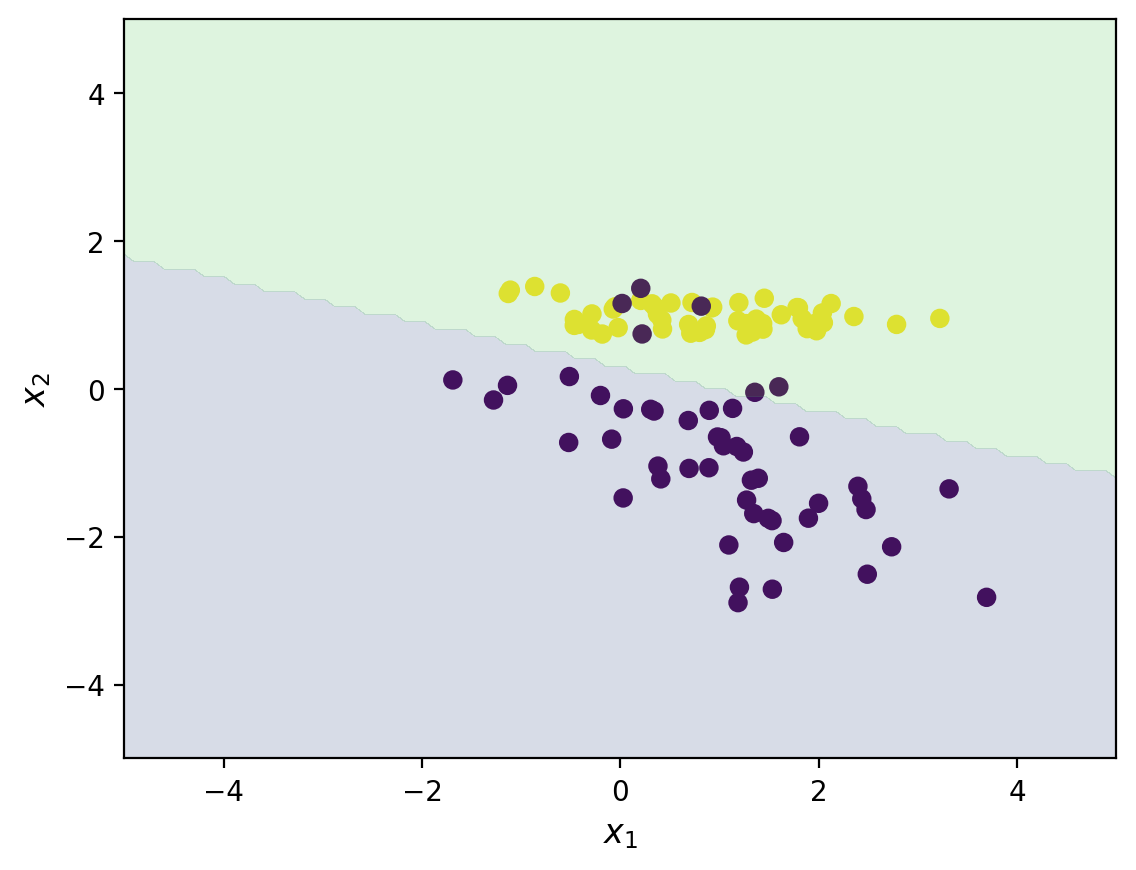

In [9]:
# number of training points
N = 100

x_train, t = make_classification(
    n_features=2, n_informative=2, n_redundant=0, n_classes=2, n_clusters_per_class=1, n_samples=N
)

x1, x2 = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
x_test = np.array([x1, x2]).reshape(2, -1).T

feature = LinearFeature()
x_train_linear = feature.transform(x_train)
x_test_linear = feature.transform(x_test)

model = LeastSquaresClassifier()
model.fit(x_train_linear, t)
predicted = model.predict(x_test_linear)

plt.scatter(x_train[:, 0], x_train[:, 1], c=t)
plt.contourf(x1, x2, predicted.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$x_2$", fontsize=12)
plt.show()

The least-squares approach gives an exact closed-form solution for the discriminant function parameters. However, even as a discriminant function (making decisions directly) it suffers from some problems. We already know that least-squares solutions lack robustness to outliers, and this applies equally to classification, as depicted in the following figure. Note that the additional outlier data points produce a change in the location of the decision boundary, even though these point would be correctly classified by the original decision boundary. The sum-of-squares error function penalizes predictions that are *too correct* in that they lie a long way on the correct side of the decision boundary.

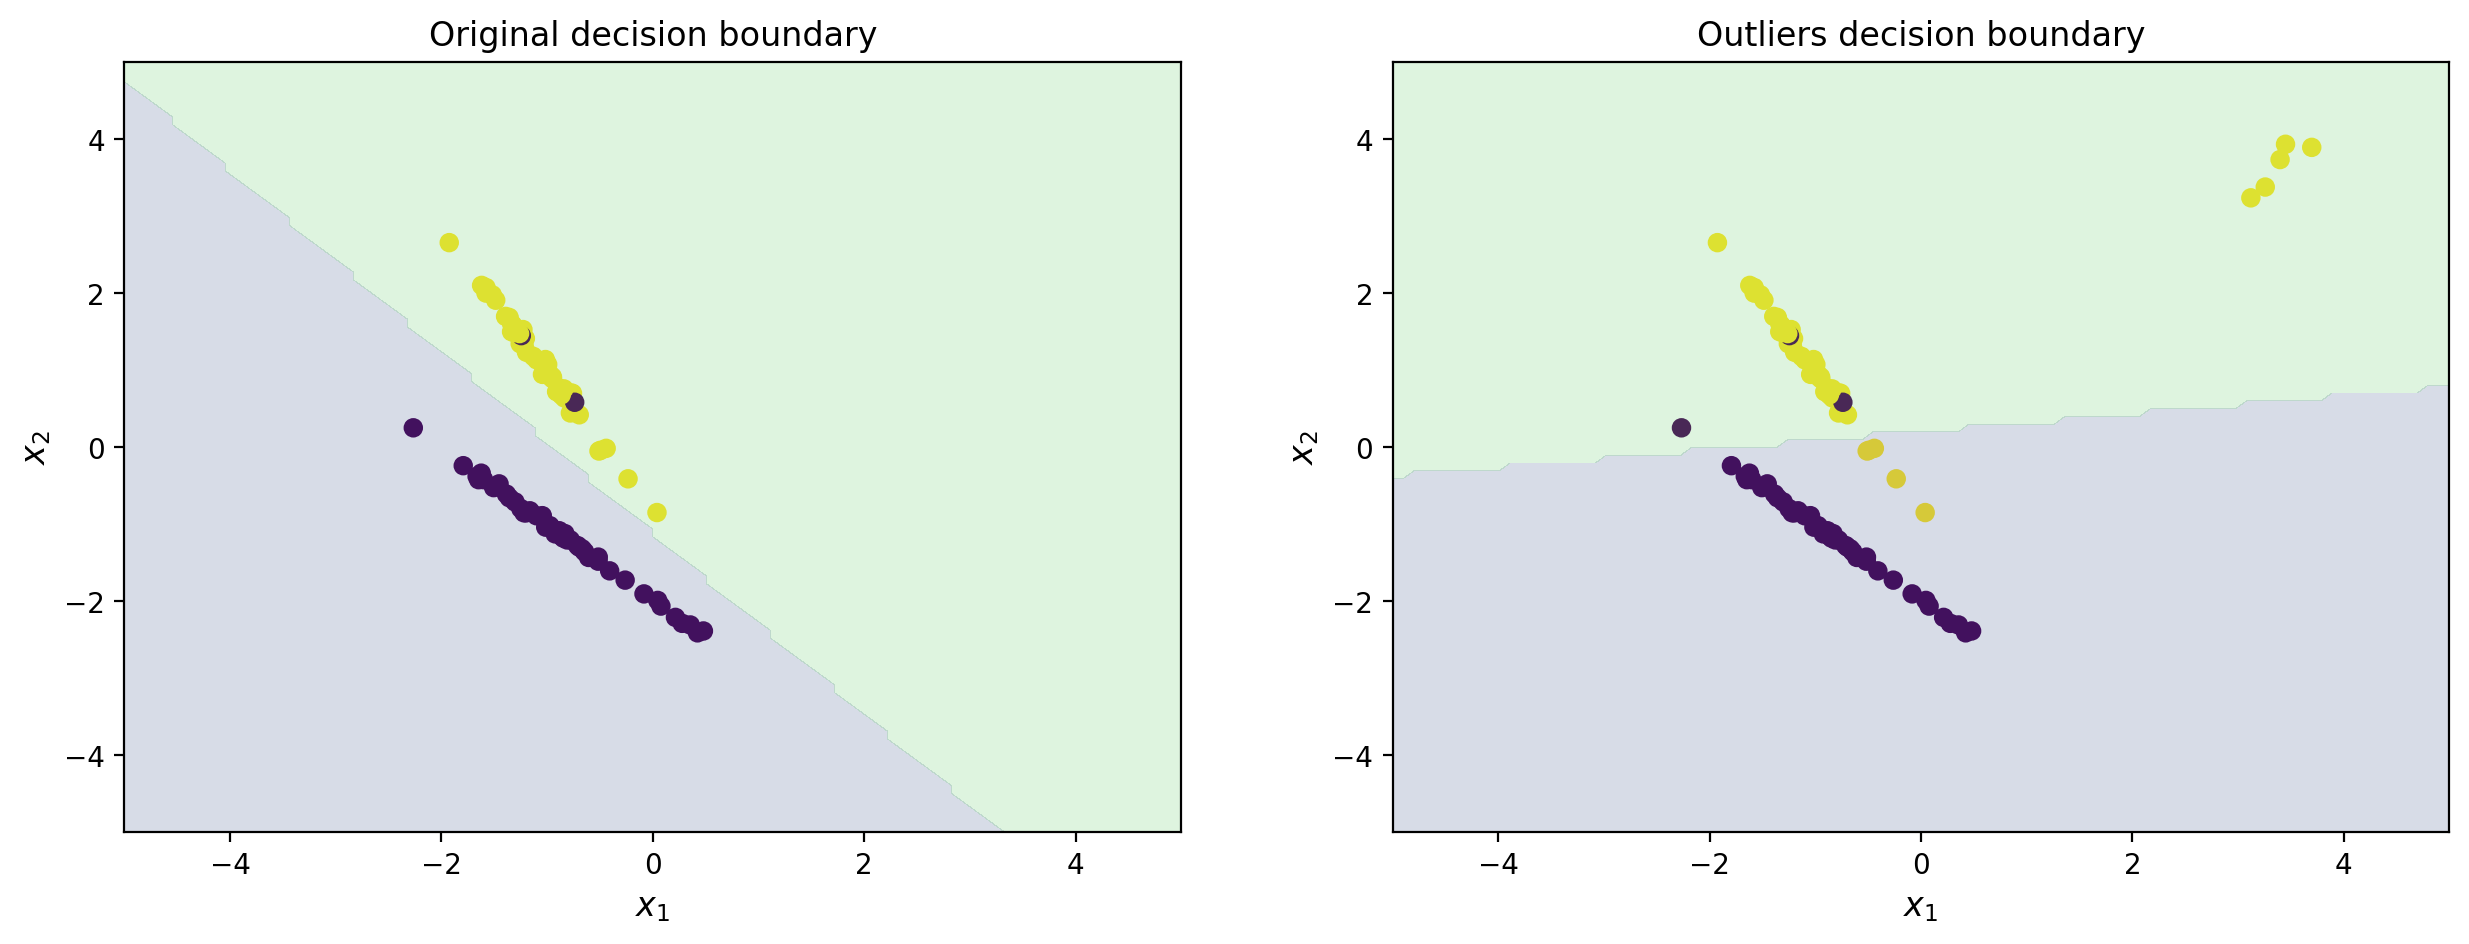

In [10]:
# number of training points
N = 100

# number of outlier points
n_outliers = 5

x_train, t = make_classification(
    n_features=2, n_informative=2, n_redundant=0, n_classes=2, n_clusters_per_class=1, n_samples=N, random_state=12
)

x1, x2 = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
x_test = np.array([x1, x2]).reshape(2, -1).T

outliers = np.random.random_sample((n_outliers, 2)) + 3
x_train_outliers = np.vstack((x_train, outliers))
t_outliers = np.hstack((t, np.ones(n_outliers, dtype=int)))

feature = LinearFeature()
x_train_linear = feature.transform(x_train)
x_train_linear_outliers = feature.transform(x_train_outliers)
x_test_linear = feature.transform(x_test)

model = LeastSquaresClassifier()
model.fit(x_train_linear, t)
predicted = model.predict(x_test_linear)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(x_train[:, 0], x_train[:, 1], c=t)
plt.contourf(x1, x2, predicted.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$x_2$", fontsize=12)
plt.title("Original decision boundary")

model.fit(x_train_linear_outliers, t_outliers)
predicted_outliers = model.predict(x_test_linear)

plt.subplot(1, 2, 2)
plt.scatter(x_train_outliers[:, 0], x_train_outliers[:, 1], c=t_outliers)
plt.contourf(x1, x2, predicted_outliers.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$x_2$", fontsize=12)
plt.title("Outliers decision boundary")

plt.show()

The failure of least squares should not surprise us since it corresponds to maximum likelihood under the assumption of a Gaussian conditional distribution, whereas binary target vectors clearly do not have a Gaussian distribution.

### 4.1.4 Fisher's linear discriminant

Consider a two-class problem in which there are $N_1$ points of class $\mathcal{C}_1$ and $N_2$ points from class $\mathcal{C}_2$, so that the mean vectors of the two classes are given by

$$
\mathbf{m}_1 = \frac{1}{N_1}\sum_{n\in\mathcal{C}_1}\mathbf{x}_n, \qquad\qquad \mathbf{m}_2 = \frac{1}{N_2}\sum_{n\in\mathcal{C}_2}\mathbf{x}_n
$$

Then, the simplest measure of separation of the classes, when projected onto $\mathbf{w}$, is the separation of the projected class means. This suggests that we might choose $\mathbf{w}$ so as to maximize 

$$
m_2 - m_1 = \mathbf{w}^T(\mathbf{m}_2 - \mathbf{m}_1)
$$

where

$$
m_k = \mathbf{w}^T\mathbf{m}_k
$$

is the mean of the projected data from class $\mathcal{C}_k$.

The idea proposed by Fisher is to maximize the function that gives a large separation between the projected class means while also giving a small variance within each class, thereby minimizing the class overlap. The within-class variance of the projected data from class $\mathcal{C}_k$ is given by,

$$
s_k^2 = \sum_{n\in\mathcal{C}_k} (y_n - m_k)^2
$$

where $y_n = \mathbf{w}^T\mathbf{x}_n$ is the projected data point in the one-dimentional space. We can further define the total within-class variance for the whole data set to be simply $s_1^2 + s_2^2$. Then, the Fisher criterion is defined as the ratio of the *between-class* variance to the *within-class* variance as follows,

$$
J(\mathbf{w}) = \frac{(m_2-m_1)^2}{s_1^2+s_2^2}
$$

In order to explicitly show the dependence on $\mathbf{w}$, we may rewrite $J(\mathbf{w})$, using $(4.20)$, $(4.23)$, and $(4.24)$, as follows,

$$
\begin{aligned}
J(\mathbf{w}) &= \frac{(m_2-m_1)^2}{s_1^2+s_2^2}\\
&= \frac{(\mathbf{w}^T\mathbf{m}_2-\mathbf{w}^T\mathbf{m}_1)^2}{\sum_{n\in\mathcal{C}_k} (y_n - m_1)^2 + \sum_{n\in\mathcal{C}_k} (y_n - m_2)^2}\\
&= \frac{(\mathbf{w}^T(\mathbf{m}_2-\mathbf{m}_1))^2}{\sum_{n\in\mathcal{C}_k} (\mathbf{w}^T(\mathbf{x}_n - \mathbf{m}_1))^2 + \sum_{n\in\mathcal{C}_k} (\mathbf{w}^T(\mathbf{x}_n - \mathbf{m}_2))^2}\\
&= \frac{\mathbf{w}^T(\mathbf{m}_2-\mathbf{m}_1)^2\mathbf{w}}{\mathbf{w}^T\big(\sum_{n\in\mathcal{C}_k} (\mathbf{x}_n - \mathbf{m}_1)^2 + \sum_{n\in\mathcal{C}_k} (\mathbf{x}_n - \mathbf{m}_2)^2\big)\mathbf{w}}\\
&=\frac{\mathbf{w}^T\mathbf{S}_B\mathbf{w}}{\mathbf{w}^T\mathbf{S}_W\mathbf{w}}
\end{aligned}
$$

Then, by computing the derivative with respect to $\mathbf{w}$, we find that $J(\mathbf{w})$ is maximized when,

$$
(\mathbf{w}^T\mathbf{S}_B\mathbf{w})\mathbf{S}_W\mathbf{w} = (\mathbf{w}^T\mathbf{S}_W\mathbf{w})\mathbf{S}_B\mathbf{w} \Leftrightarrow \mathbf{w} \propto \mathbf{S}_W^{-1}(\mathbf{m}_2-\mathbf{m}_1)
$$

This result is known as the *Fisher's linear discriminant*. To that end, the projected data are compared against a threshold $y_0$ and classified as belonging to class $\mathcal{C}_1$ if $y(\mathbf{x}) \geq y_0$, and to class $\mathcal{C}_2$ otherwise.

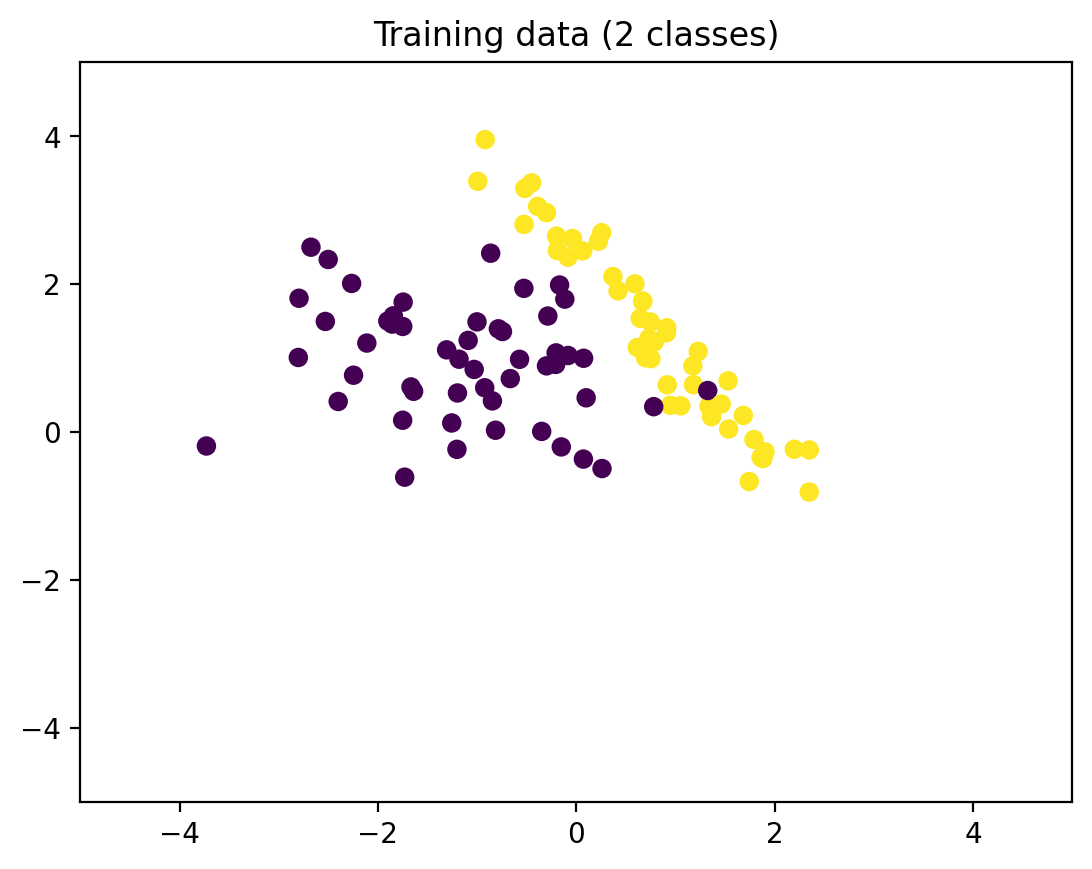

In [11]:
# number of training points
N = 100

x_train, t = make_classification(
    n_features=2, n_informative=2, n_redundant=0, n_classes=2, n_clusters_per_class=1, n_samples=N, random_state=15
)

x1, x2 = np.meshgrid(np.linspace(-5, 5, N), np.linspace(-5, 5, N))
x_test = np.array([x1, x2]).reshape(2, -1).T

plt.scatter(x_train[:, 0], x_train[:, 1], c=t)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.title("Training data (2 classes)")

plt.show()

One way of choosing the threshold $y_0$ is to model the class-conditional densities (one per class) $p(y|\mathcal{C}_k)$ as Gaussian distributions, then estimate their parameters using maximum likelihood, and finally, estimate the optimal threshold using decision theory. In the case of binary classification, we can equate the Gaussian functions and solve for $\mathbf{x}$. The result is a quadratic equation having coefficients relating to the gaussian means and variances.

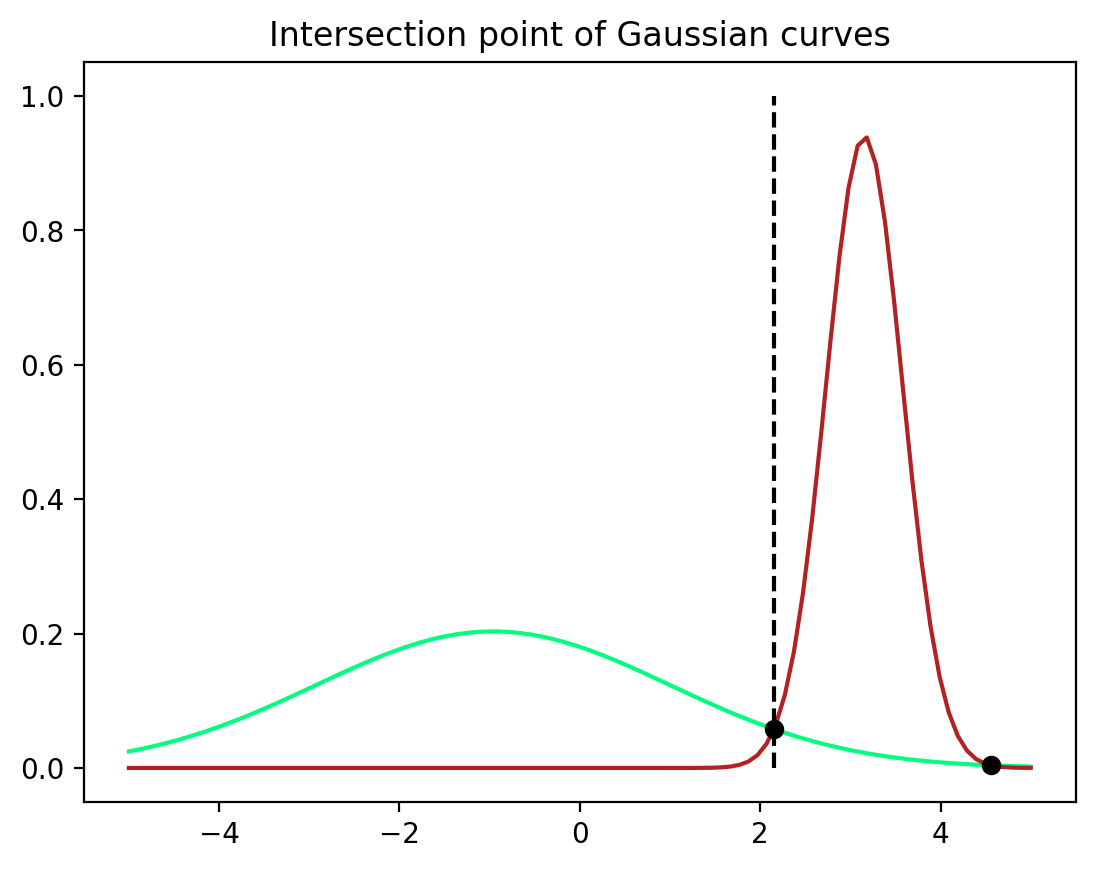

In [12]:
# split data points according to the classes
x_0 = x_train[t == 0]
x_1 = x_train[t == 1]

model = FisherLinearDiscriminant()
model.fit(x_train, t)

# create a Gaussian distribution per class
g0 = Gaussian()
g0.ml(x_0 @ model._w)
g1 = Gaussian()
g1.ml(x_1 @ model._w)

root = np.roots(
    [
        g1.var - g0.var,
        2 * (g0.var * g1.mu - g1.var * g0.mu),
        g1.var * g0.mu**2 - g0.var * g1.mu**2 - g1.var * g0.var * np.log(g1.var / g0.var),
    ]
)

x = np.linspace(-5, 5, N)
plt.plot(x, g0.pdf(x), "springgreen")
plt.plot(x, g1.pdf(x), "firebrick")
plt.plot(root[0], g0.pdf(root[0]), "ko")
plt.plot(root[1], g0.pdf(root[1]), "ko")
plt.plot(np.zeros(x.size) + root[1], np.linspace(0, 1, N), "k--")
plt.title("Intersection point of Gaussian curves")

plt.show()

The figures below compares the optimal threshold against the naive zero threshold. Note that the selection of the decision threshold is crucial for an effective model.

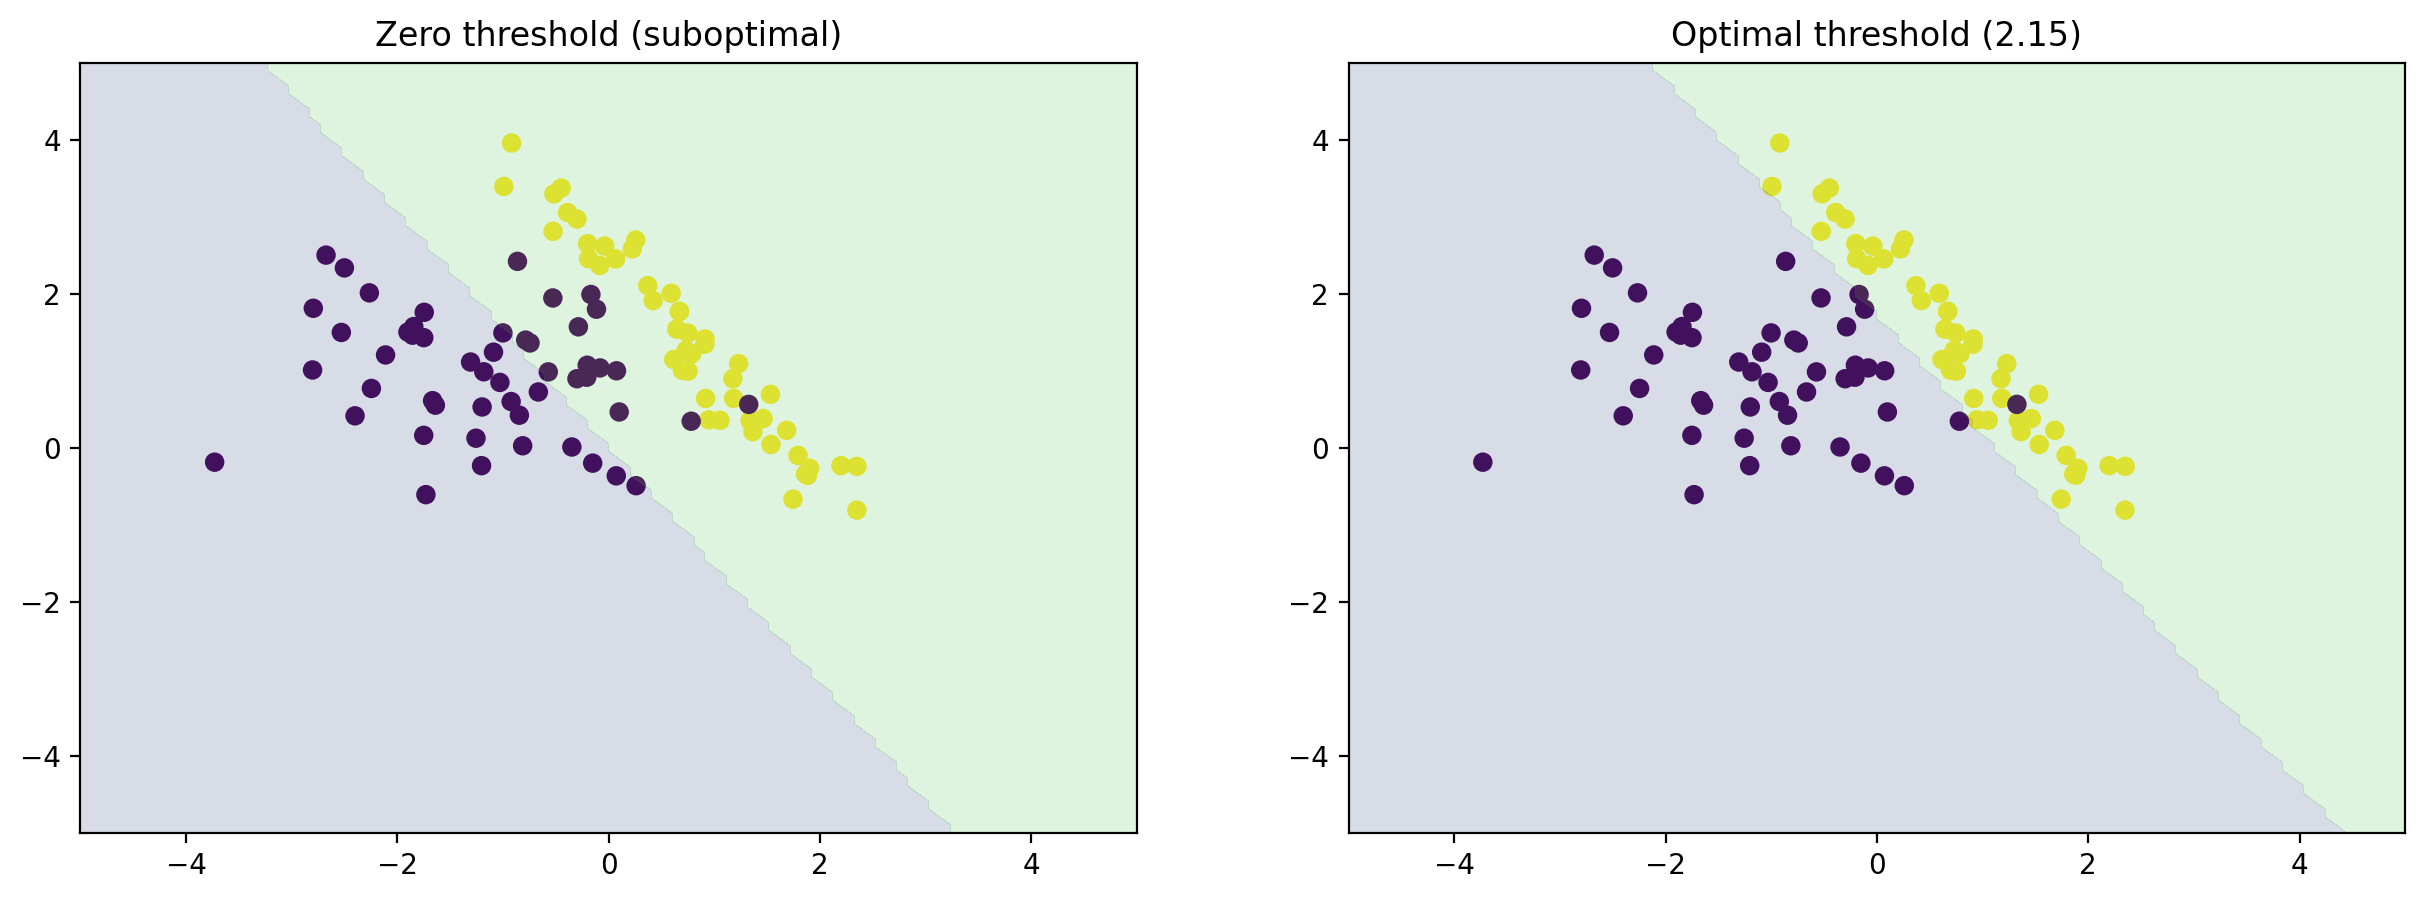

In [13]:
model = FisherLinearDiscriminant()
model.fit(x_train, t)
optimal_threshold = model._threshold

plt.figure(figsize=(15, 5))

# predict classes using the optimal threshold
predicted = model.predict(x_test)

plt.subplot(1, 2, 2)
plt.scatter(x_train[:, 0], x_train[:, 1], c=t)
plt.contourf(x1, x2, predicted.reshape(N, N), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.title(f"Optimal threshold ({round(optimal_threshold, 2)})")

# set threshold to zero and make predictions
model._threshold = 0
predicted = model.predict(x_test)

plt.subplot(1, 2, 1)
plt.scatter(x_train[:, 0], x_train[:, 1], c=t)
plt.contourf(x1, x2, predicted.reshape(N, N), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.title("Zero threshold (suboptimal)")

plt.show()

### 4.1.7 The perceptron algorithm

Another linear discriminant model is the perceptron. It corresponds to a two-class model in which the input vector $\mathbf{x}$ is first transformed using a nonlinear transformation to give a feature vector $\boldsymbol\phi(\mathbf{x})$, and then use it to construct a generalized linear model of the form

$$
y(\mathbf{x}) = f\big(\mathbf{w}^T\boldsymbol\phi(\mathbf{x})\big)
$$

We assume that the vector $\boldsymbol\phi(\mathbf{x})$ typically includes the bias component $\phi_0$. The nonlinear activation function $f(\cdot)$ is given by a step function of the form

$$
f(\alpha)=
\begin{cases}
    +1, & \quad \alpha \geq 0\\
    -1, & \quad \alpha < 0
\end{cases}
$$

That is because for the perceptron it is more convenient to use target values $t=+1$ for class $\mathcal{C}_1$ and $t=-1$ for class $\mathcal{C}_2$, instead of $t \in \{0,1\}$. We consider an error function called the *perceptron criterion*. Note that we are seeking a weight vector $\mathbf{w}$, such that the inputs $\mathbf{x}_n$, belonging in class $\mathcal{C}_1$, have $\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) > 0$, whereas the ones belonging in class $\mathcal{C}_2$, have $\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) < 0$. Given the coding scheme $t \in \{-1, +1\}$, it follows that all inputs must satisfy $\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n)t_n > 0$. Thus, the perceptron criterion tries to minimize the quantity $-\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n)t_n$, for all misclassified inputs. More formally,

$$
E_P(\mathbf{w}) = -\sum_{n\in\mathcal{M}} \mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n)t_n
$$

where $\mathcal{M}$ denotes the set of misclassified patterns.

We apply the stochastic gradient descent algorithm to the error function. Thus, the change in the weight vector, according to gradient descent, is given by,

$$
\mathbf{w}^{(\tau+1)} = \mathbf{w}^{(\tau)} - \eta\nabla E_P(\mathbf{w}) = \mathbf{w}^{(\tau)} + \eta\boldsymbol\phi_nt_n
$$

The *perceptron convergence theorem* states that if there exists an exact solution (the data are linearly separable), the the perceptron algorithm is guaranteed to find the solution in a finite number of steps. On the other hand, if the data are not linearly separable the perceptron never converges. Moreover, note that the perceptron **does not provide probabilistic outputs, nor does it generalize to $K>2$ classes**.

Another important limitation arises from the fact that it is based on linear combinations of fixed basis functions.

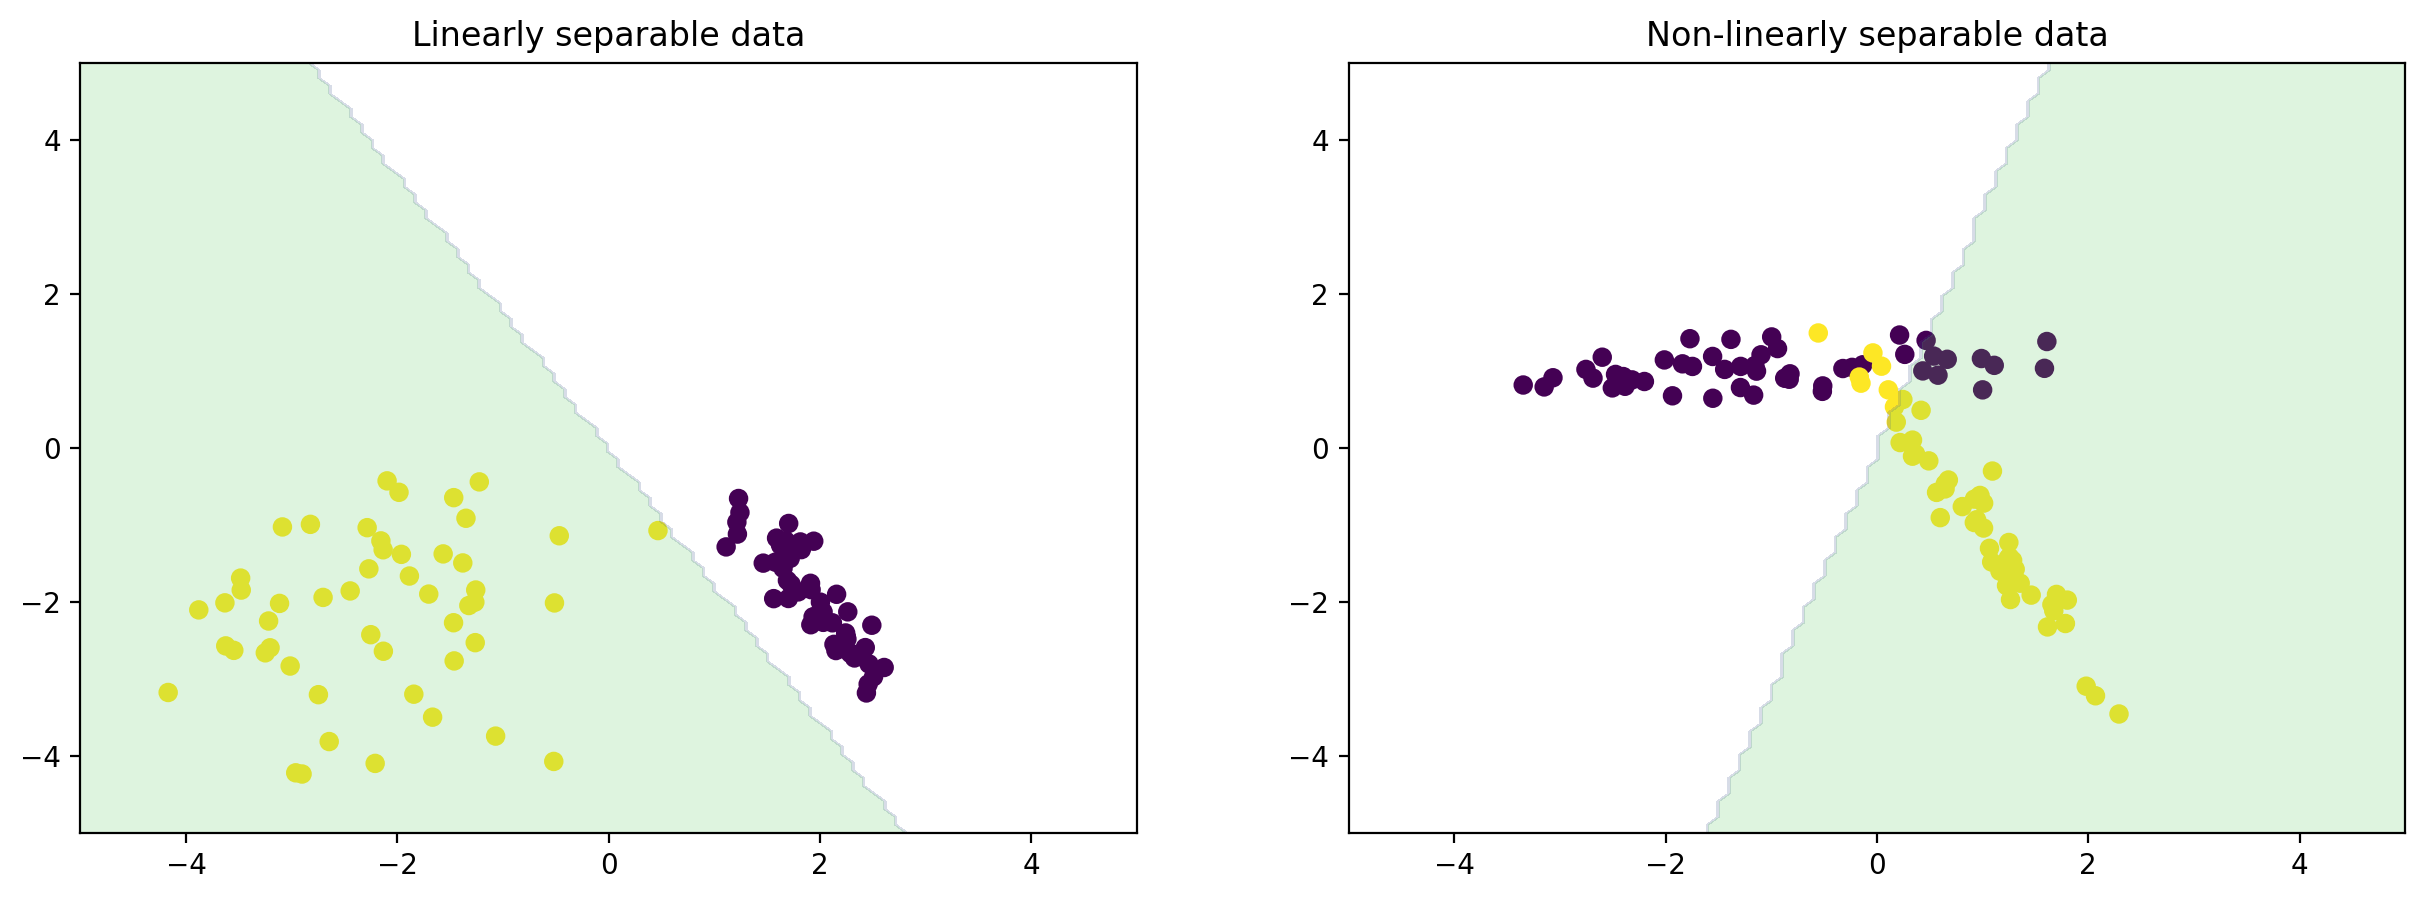

In [14]:
# number of training points
N = 100

x1, x2 = np.meshgrid(np.linspace(-5, 5, N), np.linspace(-5, 5, N))
x_test = np.array([x1, x2]).reshape(2, -1).T

model = Perceptron()

plt.figure(figsize=(15, 5))

x_train, t = make_classification(
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_classes=2,
    n_clusters_per_class=1,
    n_samples=N,
    random_state=10,
    class_sep=2,
)

model.fit(x_train, np.where(t == 0, -1, 1))
predicted = model.predict(x_test)

plt.subplot(1, 2, 1)
plt.scatter(x_train[:, 0], x_train[:, 1], c=t)
plt.contourf(x1, x2, predicted.reshape(N, N), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.title("Linearly separable data")

x_train, t = make_classification(
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_classes=2,
    n_clusters_per_class=1,
    n_samples=N,
    random_state=14,
)

model.fit(x_train, np.where(t == 0, -1, 1))
predicted = model.predict(x_test)

plt.subplot(1, 2, 2)
plt.scatter(x_train[:, 0], x_train[:, 1], c=t)
plt.contourf(x1, x2, predicted.reshape(N, N), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.title("Non-linearly separable data")

plt.show()

## 4.2 Probabilistic Generative Models

Models having linear decision boundaries arise from simple assumptions about the distribution of the data. A generative approach models the class-conditional densities $p(\mathbf{x}|\mathcal{C}_k)$, as well as the class priors $p(\mathcal{C}_k)$, and use them to compute the posterior probability $p(\mathcal{C}_k|\mathbf{x})$ throught *Bayes theorem*. To that end, the posterior probability for class $\mathcal{C}_1$, in a binary classification problem, is as follows,

$$
\begin{aligned}
p(\mathcal{C}_1|\mathbf{x}) &= \frac{p(\mathbf{x}|\mathcal{C}_1)p(\mathcal{C}_1)}{p(\mathbf{x})} \\
&= \frac{p(\mathbf{x}|\mathcal{C}_1)p(\mathcal{C}_1)}{p(\mathbf{x}|\mathcal{C}_1)p(\mathcal{C}_1) + p(\mathbf{x}|\mathcal{C}_2)p(\mathcal{C}_2)} \\
&= \frac{1}{1 + \exp(-\alpha)} = \sigma(\alpha)
\end{aligned}
$$

where,

$$
\alpha = \ln\frac{p(\mathbf{x}|\mathcal{C}_1)p(\mathcal{C}_1)}{p(\mathbf{x}|\mathcal{C}_2)p(\mathcal{C}_2)}
$$

*Proof*

$$
\begin{aligned}
\sigma(\alpha) &= \frac{1}{1 + \exp(-\alpha)} \\
&= \frac{1}{1 + \frac{1}{\exp(\alpha)}} = \frac{\exp(\alpha)}{1 + \exp(\alpha)} \\
&= \frac{\exp\big(\ln\frac{p(\mathbf{x}|\mathcal{C}_1)p(\mathcal{C}_1)}{p(\mathbf{x}|\mathcal{C}_2)p(\mathcal{C}_2)}\big)}{1 + \exp\big(\ln\frac{p(\mathbf{x}|\mathcal{C}_1)p(\mathcal{C}_1)}{p(\mathbf{x}|\mathcal{C}_2)p(\mathcal{C}_2)}\big)} \\
&= \frac{\frac{p(\mathbf{x}|\mathcal{C}_1)p(\mathcal{C}_1)}{p(\mathbf{x}|\mathcal{C}_2)p(\mathcal{C}_2)}}{1 + \frac{p(\mathbf{x}|\mathcal{C}_1)p(\mathcal{C}_1)}{p(\mathbf{x}|\mathcal{C}_2)p(\mathcal{C}_2)}}
= \frac{\frac{p(\mathbf{x}|\mathcal{C}_1)p(\mathcal{C}_1)}{p(\mathbf{x}|\mathcal{C}_2)p(\mathcal{C}_2)}}{\frac{p(\mathbf{x}|\mathcal{C}_1)p(\mathcal{C}_1) + p(\mathbf{x}|\mathcal{C}_2)p(\mathcal{C}_2)}{p(\mathbf{x}|\mathcal{C}_2)p(\mathcal{C}_2)}} \\
&= \frac{p(\mathbf{x}|\mathcal{C}_1)p(\mathcal{C}_1)p(\mathbf{x}|\mathcal{C}_2)p(\mathcal{C}_2)}{p(\mathbf{x}|\mathcal{C}_2)p(\mathcal{C}_2)\big(p(\mathbf{x}|\mathcal{C}_1)p(\mathcal{C}_1) + p(\mathbf{x}|\mathcal{C}_2)p(\mathcal{C}_2)\big)} \\
&= \frac{p(\mathbf{x}|\mathcal{C}_1)p(\mathcal{C}_1)}{p(\mathbf{x}|\mathcal{C}_1)p(\mathcal{C}_1) + p(\mathbf{x}|\mathcal{C}_2)p(\mathcal{C}_2)}
\end{aligned}
$$

The function $\sigma(\alpha)$ is the **logistic sigmoid** briefly presented in [Chapter 3](ch3_linear_models_for_regression.ipynb).

For $K>2$ classes, the posterior for class $\mathcal{C}_k$ is as follows,

$$
\begin{aligned}
p(\mathcal{C}_k|\mathbf{x}) &= \frac{p(\mathbf{x}|\mathcal{C}_k)p(\mathcal{C}_k)}{p(\mathbf{x})} \\
&= \frac{p(\mathbf{x}|\mathcal{C}_k)p(\mathcal{C}_k)}{\sum_i p(\mathbf{x}|\mathcal{C}_i)} \\
&= \frac{\exp(\alpha_k)}{\sum_i \exp(\alpha_i)}
\end{aligned}
$$

which is known as the *normalized exponential* and can be regarded as a multiclass generalization of the logistic sigmoid function. The quantities $\alpha_k$ are defined as follows,

$$
\alpha_k = \ln(p(\mathbf{x}|\mathcal{C}_k)p(\mathcal{C}_k))
$$

The normalized exponential is also known as the *softmax function*, since it represents a smoothed version of the max function, because if $\alpha_k \gg \alpha_i\; \forall i \neq k$, then $p(\mathcal{C}_k|\mathbf{x}) \approx 1$ and $p(\mathcal{C}_i|\mathbf{x}) \approx 0$.

### 4.2.1 Continuous inputs

Given the formulation above, the next step is to assume the form of the class-conditional densities. The Gaussian distributions may be used for modelling continuous variables. Assuming that all classes share the same covariance matrix, the density for class $\mathcal{C}_k$ is given by

$$
p(\mathbf{x}|\mathcal{C}_k) = \mathcal{N}(\mathbf{x}|\boldsymbol\mu_k, \Sigma)
$$

Thus, from $(4.58)$, we have,

$$
\begin{aligned}
\alpha &= \ln\frac{p(\mathbf{x}|\mathcal{C}_1)p(\mathcal{C}_1)}{p(\mathbf{x}|\mathcal{C}_2)p(\mathcal{C}_2)}
= \ln\frac{\mathcal{N}(\mathbf{x}|\boldsymbol\mu_1, \Sigma)p(\mathcal{C}_1)}{\mathcal{N}(\mathbf{x}|\boldsymbol\mu_2, \Sigma)p(\mathcal{C}_2)} \\
&= \ln\frac{\mathcal{N}(\mathbf{x}|\boldsymbol\mu_1, \Sigma)}{\mathcal{N}(\mathbf{x}|\boldsymbol\mu_2, \Sigma)}
+ \ln\frac{p(\mathcal{C}_1)}{p(\mathcal{C}_2)} \\
&= \ln\frac{\exp\big\{-\frac{1}{2}(\mathbf{x}-\boldsymbol\mu_1)^T\Sigma^{-1}(\mathbf{x}-\boldsymbol\mu_1)\big\}}{\exp\big\{-\frac{1}{2}(\mathbf{x}-\boldsymbol\mu_2)^T\Sigma^{-1}(\mathbf{x}-\boldsymbol\mu_2)\big\}}
+ \ln\frac{p(\mathcal{C}_1)}{p(\mathcal{C}_2)} \\
&= -\frac{1}{2}(\mathbf{x}-\boldsymbol\mu_1)^T\Sigma^{-1}(\mathbf{x}-\boldsymbol\mu_1) + \frac{1}{2}(\mathbf{x}-\boldsymbol\mu_2)^T\Sigma^{-1}(\mathbf{x}-\boldsymbol\mu_2) + \ln\frac{p(\mathcal{C}_1)}{p(\mathcal{C}_2)} \\
&= - \frac{1}{2}\mathbf{x}^T\Sigma^{-1}\mathbf{x} + \boldsymbol\mu_1^T\Sigma^{-1}\mathbf{x} - \frac{1}{2}\boldsymbol\mu_1^T\Sigma^{-1}\boldsymbol\mu_1
+ \frac{1}{2}\mathbf{x}^T\Sigma^{-1}\mathbf{x} - \boldsymbol\mu_2^T\Sigma^{-1}\mathbf{x} + \frac{1}{2}\boldsymbol\mu_2^T\Sigma^{-1}\boldsymbol\mu_2 + \ln\frac{p(\mathcal{C}_1)}{p(\mathcal{C}_2)} \\
&= \boldsymbol\mu_1^T\Sigma^{-1}\mathbf{x} - \boldsymbol\mu_2^T\Sigma^{-1}\mathbf{x} - \frac{1}{2}\boldsymbol\mu_1^T\Sigma^{-1}\boldsymbol\mu_1 + \frac{1}{2}\boldsymbol\mu_2^T\Sigma^{-1}\boldsymbol\mu_2 + \ln\frac{p(\mathcal{C}_1)}{p(\mathcal{C}_2)} \\
&= (\boldsymbol\mu_1 - \boldsymbol\mu_2)^T\Sigma^{-1}\mathbf{x} - \frac{1}{2}\boldsymbol\mu_1^T\Sigma^{-1}\boldsymbol\mu_1 + \frac{1}{2}\boldsymbol\mu_2^T\Sigma^{-1}\boldsymbol\mu_2 + \ln\frac{p(\mathcal{C}_1)}{p(\mathcal{C}_2)}
\end{aligned}
$$

To that end, using $(4.57)$, we derive that,

$$
p(\mathcal{C}_1|\mathbf{x}) = \sigma(\mathbf{w}^T\mathbf{x} + w_0)
$$

where,

$$
\begin{aligned}
\mathbf{w} &= \Sigma^{-1}(\boldsymbol\mu_1-\boldsymbol\mu_2) \\
w_0 &= -\frac{1}{2}\boldsymbol\mu_1^T\Sigma^{-1}\boldsymbol\mu_1 + \frac{1}{2}\boldsymbol\mu_2^T\Sigma^{-1}\boldsymbol\mu_2 + \ln\frac{p(\mathcal{C}_1)}{p(\mathcal{C}_2)}
\end{aligned}
$$

Note that the prior probabilities $p(\mathcal{C}_k)$ enter through the bias parameter $w_0$, thus making parallel shifts of the decision boundary.

For the general case of $K$ classes, from $(4.63)$, we have, 

$$
\begin{aligned}
\alpha_k &= \ln\Big(\frac{1}{(2\pi)^{D/2}}\Big) + \ln\Big(\frac{1}{|\Sigma|^{1/2}}\Big) -\frac{1}{2}(\mathbf{x}-\boldsymbol\mu_k)^T\Sigma^{-1}(\mathbf{x}-\boldsymbol\mu_k) + \ln p(\mathcal{C}_k) \\
&= \ln\Big(\frac{1}{(2\pi)^{D/2}}\Big) + \ln\Big(\frac{1}{|\Sigma|^{1/2}}\Big) - \frac{1}{2}\mathbf{x}^T\Sigma^{-1}\mathbf{x} + \boldsymbol\mu_k^T\Sigma^{-1}\mathbf{x} - \frac{1}{2}\boldsymbol\mu_k^T\Sigma^{-1}\boldsymbol\mu_k + \ln p(\mathcal{C}_k) \\
&= \ln A + \ln B + Q + \mathbf{w}_k^T\mathbf{x} + w_{k0}
\end{aligned}
$$

where,

$$
\begin{aligned}
A &= \ln\Big(\frac{1}{(2\pi)^{D/2}}\Big) \\
B &= \ln\Big(\frac{1}{|\Sigma|^{1/2}}\Big) \\
Q &= - \frac{1}{2}\mathbf{x}^T\Sigma^{-1}\mathbf{x} \\
\mathbf{w}_k &= \Sigma^{-1}\mu_k \\
\mathbf{w}_{k0} &= - \frac{1}{2}\boldsymbol\mu_k^T\Sigma^{-1}\boldsymbol\mu_k + \ln p(\mathcal{C}_k)
\end{aligned}
$$

Then using $(4.62)$, we derive,

$$
\begin{aligned}
p(\mathcal{C}_k|\mathbf{x}) &= \frac{\exp(\alpha_k)}{\sum_j \exp(\alpha_j)} \\
&= \frac{\exp(A + B + Q)\exp(\mathbf{w}_k^T\mathbf{x} + w_{k0})}{\exp(A + B + Q) \sum_j \exp(\mathbf{w}_j^T\mathbf{x} + w_{j0})}
\end{aligned}
$$

and re-define $\alpha_k$ as follows,

$$
a_k(\mathbf{x}) = \mathbf{w}_k^T\mathbf{x} + w_{k0}
$$

Therefore, we see that for $K>2$ classes, $\alpha_k$ are linear functions of $\mathbf{x}$ since quadratic terms cancel each other due to the shared covariances. By relaxing the assumption of the shared covariance matrix among the classes, allowing each class to have each won covariance matrix $\Sigma_k$, then we obtain quadratic functions of $\mathbf{x}$, giving rise to *quadratic discriminant*.

### 4.2.2 Maximum likelihood solution

Given a set of data, comprising observations $\mathbf{x}$ and corresponding class labels, we can determine the parameters of the class-conditional densities and class prior probabilities, using maximum likelihood. Suppose that we are given a dataset $\{\mathbf{x},t_n\}$, where $t_n=1$ denotes class $\mathcal{C}_1$ and $t_n=0$ denotes $\mathcal{C}_2$. Then, for a data point $\mathbf{x}_n$ belonging to class $\mathcal{C}_1$ ($t_n=1$), we have,

$$
p(\mathbf{x}_n,\mathcal{C}_1) = p(\mathcal{C}_1)p(\mathbf{x}_n|\mathcal{C}_1) = \pi\mathcal{N}(\mathbf{x}_n|\boldsymbol\mu_1, \Sigma)
$$

Similarly, for class $\mathcal{C}_2$ ($t_n=0$),

$$
p(\mathbf{x}_n,\mathcal{C}_2) = p(\mathcal{C}_2)p(\mathbf{x}_n|\mathcal{C}_2) =(1-\pi)\mathcal{N}(\mathbf{x}_n|\boldsymbol\mu_2, \Sigma)
$$

where $p(\mathcal{C}_1)=\pi$ and complementary $p(\mathcal{C}_2)=1-\pi$.

Thus, the likelihood function is given by,

$$
p(\mathbf{t},\mathbf{X}|\pi,\boldsymbol\mu_1,\boldsymbol\mu_2,\Sigma) = \prod_{n=1}^N \big[\pi\mathcal{N}(\mathbf{x}_n|\boldsymbol\mu_1, \Sigma)\big]^{t_n} \big[(1-\pi)\mathcal{N}(\mathbf{x}_n|\boldsymbol\mu_2, \Sigma)\big]^{1-t_n}
$$

and the log-likelihood is as follows,

$$
\ln p(\mathbf{t},\mathbf{X}|\pi,\boldsymbol\mu_1,\boldsymbol\mu_2,\Sigma) = \sum_{n=1}^N t_n\big(\ln\pi +\ln\mathcal{N}(\mathbf{x}_n|\boldsymbol\mu_1, \Sigma)\big) + (1-t_n)\big(\ln(1-\pi) + \ln\mathcal{N}(\mathbf{x}_n|\boldsymbol\mu_2, \Sigma)\big)
$$

1. Setting the derivative for $\pi$ equal to zero, we obtain,

$$
\begin{aligned}
&\frac{d}{d\pi} \ln p(\mathbf{t},\mathbf{X}|\pi,\boldsymbol\mu_1,\boldsymbol\mu_2,\Sigma) = 0 \Leftrightarrow \\ 
&\frac{d}{d\pi} \sum_{n=1}^N\{t_n\ln\pi + (1-t_n)\ln(1-\pi)\} = 0 \Leftrightarrow \\
&\frac{1}{\pi}\sum_{n=1}^N t_n - \frac{1}{1-\pi}\sum_{n=1}^N(1-t_n) = 0 \Leftrightarrow \\
&\frac{1}{\pi}\sum_{n=1}^N t_n - \frac{1}{1-\pi}(N-\sum_{n=1}^N t_n) = 0 \Leftrightarrow \\
&\frac{1}{\pi}\sum_{n=1}^N t_n = \frac{1}{1-\pi}(N-\sum_{n=1}^N t_n) \Leftrightarrow \\
&\frac{1-\pi}{\pi}\sum_{n=1}^N t_n = N-\sum_{n=1}^N t_n \Leftrightarrow \\
&\frac{1}{\pi}\sum_{n=1}^N t_n - \sum_{n=1}^N t_n = N-\sum_{n=1}^N t_n \Leftrightarrow \\
&\pi = \frac{1}{N}\sum_{n=1}^N t_n
\end{aligned}
$$

As expected, the maximum likelihood estimate for $\pi$, is simply the fraction of points in class $\mathcal{C}_1$.

2. Setting the derivative for $\boldsymbol\mu_1$ equal to zero, we obtain,

$$
\begin{aligned}
&\frac{d}{d\boldsymbol\mu_1} \ln p(\mathbf{t},\mathbf{X}|\pi,\boldsymbol\mu_1,\boldsymbol\mu_2,\Sigma) = 0 
\Leftrightarrow \\ 
&\frac{d}{d\boldsymbol\mu_1} \sum_{n=1}^N t_n\ln\mathcal{N}(\mathbf{x}_n|\boldsymbol\mu_1, \Sigma) = 0 
\Leftrightarrow \\
&\frac{d}{d\boldsymbol\mu_1} \bigg[ -\frac{1}{2}\sum_{n=1}^N t_n(\mathbf{x}_n-\boldsymbol\mu_1)^T\Sigma^{-1}(\mathbf{x}_n-\boldsymbol\mu_1) \bigg] = 0 \Leftrightarrow \\
&-\frac{1}{2}\sum_{n=1}^N -2t_n\Sigma^{-1}(\mathbf{x}_n-\boldsymbol\mu_1) = 0 \Leftrightarrow \\
&\sum_{n=1}^N t_n(\mathbf{x}_n-\boldsymbol\mu_1) = 0 \overset{\sum_{n=1}^N t_n = N_1}{\Leftrightarrow} \\
&\sum_{n=1}^N t_n\mathbf{x}_n = N_1\boldsymbol\mu_1 \Leftrightarrow \\
&\boldsymbol\mu_1 = \frac{1}{N_1}\sum_{n=1}^N t_n\mathbf{x}_n
\end{aligned}
$$

3. Similarly, the corresponding result for $\boldsymbol\mu_2$ is given by,

$$
\boldsymbol\mu_2 = \frac{1}{N_2}\sum_{n=1}^N (t_n-1)\mathbf{x}_n
$$

4. Finally, the solution for the shared covariance matrix $\Sigma$ is similar to the one derived for the multivariate Gaussian distribution is [Chapter 2](ch2_probability_distributions.ipynb), where the matrix $\Sigma$ is defined in $(4.78)$, $(4.79)$, and $(4.80)$.

**Note**: Fitting Gaussian distributions to the classes is not robust to outliers, because the maximum likelihood estimation of a Gaussian is not robust itself.


### 4.2.3 Discrete features

Consider the case of discrete binary feature values $x_i \in \{0, 1\}$. When there are $D$ inputs, then a general distribution would correspond to $2^D-1$ independent variables. Assuming a *naive Bayes* approach, we have the following class-conditional mass functions,

$$
p(\mathbf{x}|\mathcal{C}_k) = \prod_{i=1}^D \mu_{ki}^{x_i}(1-\mu_{ki})^{1-x_i}
$$

For $K$ classes, substituting into $(4.63)$, gives,

$$
\alpha_k(\mathbf{x}) = \sum_{i=1}^D \big(x_i\ln\mu_{ki} + (1-x_i)\ln(1-\mu_{ki})\big) + \ln p(\mathcal{C}_k)
$$

In the more general case, where discrete variables can take $M > 2$ states, the class-conditional mass functions are defined as follows,

$$
p(\mathbf{x}|\mathcal{C}_k) = \prod_{i=1}^D\prod_{m=1}^M \mu_{kim}^{\phi(x_i)_m}
$$

where $\phi(x_i)$ produces a $1$-of-$M$ binary coding scheme, where only one of the value among $\phi(x_i)_1,\dots,\phi(x_i)_M$ is $1$, and the others are all $0$. Thus, by substituting the expression above into $(4.63)$, gives,

$$
\alpha_k(\mathbf{x}) = \sum_{i=1}^D\sum_{m=1}^M \big(\phi(x_i)_m\ln\mu_{kim}\big) + \ln p(\mathcal{C}_k)
$$

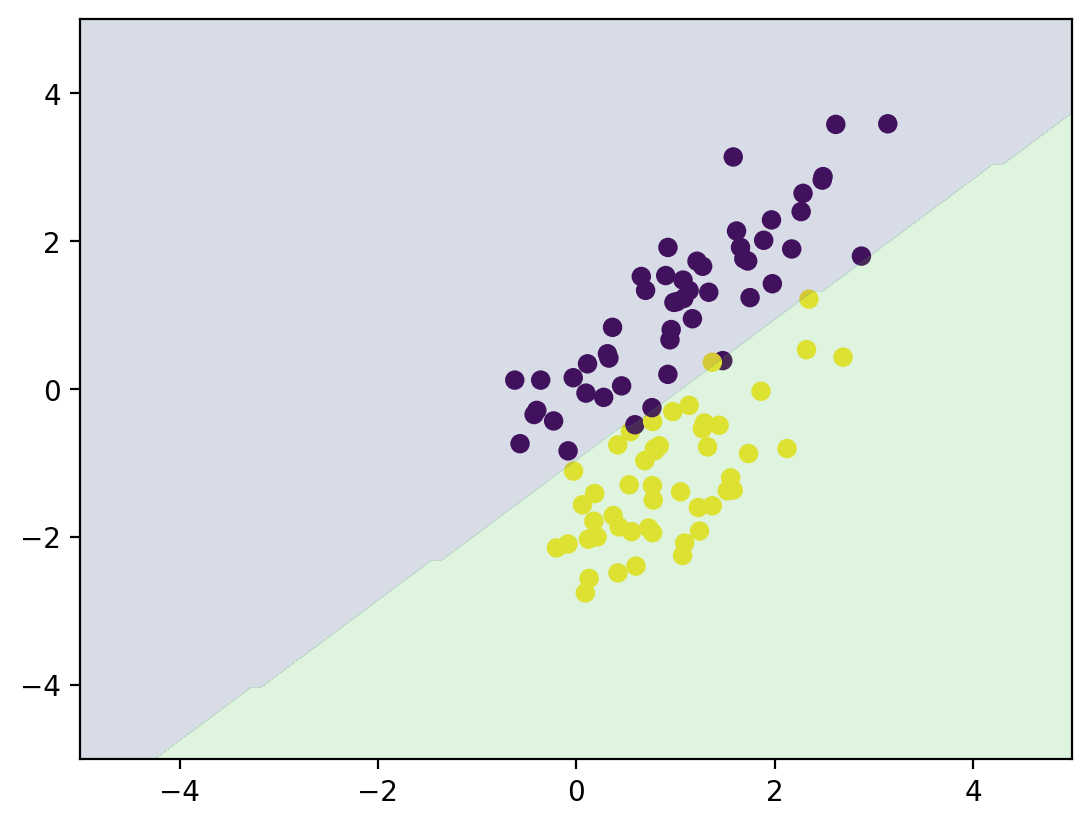

In [15]:
# number of training points
N = 100

x_train, t = make_classification(
    n_features=2, n_informative=2, n_redundant=0, n_classes=2, n_clusters_per_class=1, n_samples=N, random_state=21
)

x1, x2 = np.meshgrid(np.linspace(-5, 5, N), np.linspace(-5, 5, N))
x_test = np.array([x1, x2]).reshape(2, -1).T

model = GenerativeClassifier()
model.fit(x_train, t)
predicted = model.predict(np.array([np.ravel(x1), np.ravel(x2)]))

plt.scatter(x_train[:, 0], x_train[:, 1], c=t)
plt.contourf(x1, x2, predicted.reshape(N, N), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

## 4.3 Probabilistic Discriminative Models

An alternative approach, called *discriminative training*, is to directly maximize the likelihood function defined through the conditional distribution $p(\mathcal{C}_k|\mathbf{x})$.

### 4.3.2 Logistic Regression

Consider the binary classification problem. In the analysis of generative approaches we saw that under rather general assumptions, the posterior probability of class $\mathcal{C}_1$ can be expressed as a logistic sigmoid acting on a linear function of the input vectors $\mathbf{x}$ or the feature vector $\boldsymbol\phi$ (see $4.65$) so that,

$$
p(\mathcal{C}_1|\boldsymbol\phi) = y(\boldsymbol\phi) = \sigma(\mathbf{w}^T\boldsymbol\phi)
$$

In the terminology of statistics, this model is known as *logistic regression*, although its a classification model.

> One advantage of the discriminative approach is that there are typically fewer adaptive parameters to be determined. For an $M$-dimensional feature space, this model has $M$ adjustable parameters. By contrast, the generative model using Gaussian class conditional densities, would have used $2M$ parameters for the means and $M(M+1)/2$ parameters for the (shared) covariance matrix.

We can use maximum likelihood to determine the parameters of the logistic regression model. Given a data set $\{\boldsymbol\phi_n, t_n\}$, where $t_n\in\{0,1\}$, the likelihood function is given by,

$$
p(\mathbf{t}|\boldsymbol{\Phi},\mathbf{w}) = \prod_{n=1}^N p(\mathcal{C}_1|\boldsymbol\phi_n)^{t_n}\big(1-p(\mathcal{C}_1|\boldsymbol\phi_n)\big)^{1-t_n} = \prod_{n=1}^N y_n^{t_n}\{1-y_n\}^{1-t_n}
$$

The maximum likelihood is equivalent to the minimum of the negative of the logarithm of the likelihood, which gives the *cross-entropy error function*,

$$
E(\mathbf{w}) = -\ln p(\mathbf{t}|\boldsymbol{\Phi},\mathbf{w}) = - \sum_{n=1}^N t_n \ln y_n + (1-t_n)\ln(1-y_n)
$$

> **Why is the error function called cross-entropy?**
> 
> The cross-entropy for discrete probability distributions $p$ and $q$ is defined as $H(p,q)=\sum_{x} p(x)\log q(x)$. Since we assume that the target variables $t_n$ are probabilities taking only extreme values $0$ or $1$, and $y_n$ is a probability distribution, then $E(\mathbf{w})$ can be interpreted as the cross entropy of the target variables and the posterior probability distribution.

Then, taking the gradient of the error function over $\mathbf{w}$, we obtain,

$$
\begin{aligned}
\nabla E(\mathbf{w}) &= -\nabla\ln p(\mathbf{t}|\boldsymbol{\Phi},\mathbf{w}) \\
&= -\nabla \sum_{n=1}^N t_n \ln y_n + (1-t_n)\ln(1-y_n) \\
&= -\sum_{n=1}^N \frac{d}{dy_n}t_n \ln y_n + \frac{d}{dy_n}(1-t_n)\ln(1-y_n) \\
&\overset{\frac{d}{dx}\ln f(x)=\frac{f'(x)}{f(x)}}{=} -\sum_{n=1}^N \frac{d}{dy_n}t_n \ln y_n + \frac{d}{dy_n}(1-t_n)\ln(1-y_n) \\
&= -\sum_{n=1}^N \frac{t_n}{y_n}\frac{d}{da_n}y_n\frac{d}{d\mathbf{w}}a_n - \frac{1-t_n}{1-y_n}\frac{d}{da_n}y_n\frac{d}{d\mathbf{w}}a_n \\
&= -\sum_{n=1}^N \big(\frac{t_n}{y_n} - \frac{1-t_n}{1-y_n}\big)\frac{d}{da_n}y_n\frac{d}{d\mathbf{w}}a_n \\
&= -\sum_{n=1}^N \big(\frac{t_n}{y_n} - \frac{1-t_n}{1-y_n}\big)y_n(1-y_n)\boldsymbol{\phi}_n \\
&\overset{(4.88)}{=} -\sum_{n=1}^N \frac{t_n-y_n}{y_n(1-t_n)}y_n(1-y_n)\boldsymbol{\phi}_n \\
&= \sum_{n=1}^N (y_n - t_n)\boldsymbol{\phi}_n
\end{aligned}
$$

Note that the gradient takes the same form as the gradient of the sum-of-squares error function, however, $y_n$ involves a non-linear function. At this point we can make use of $(4.91)$ and $(3.22)$ to obtain a sequential algorithm (gradient descent) for optimizing the parameters.

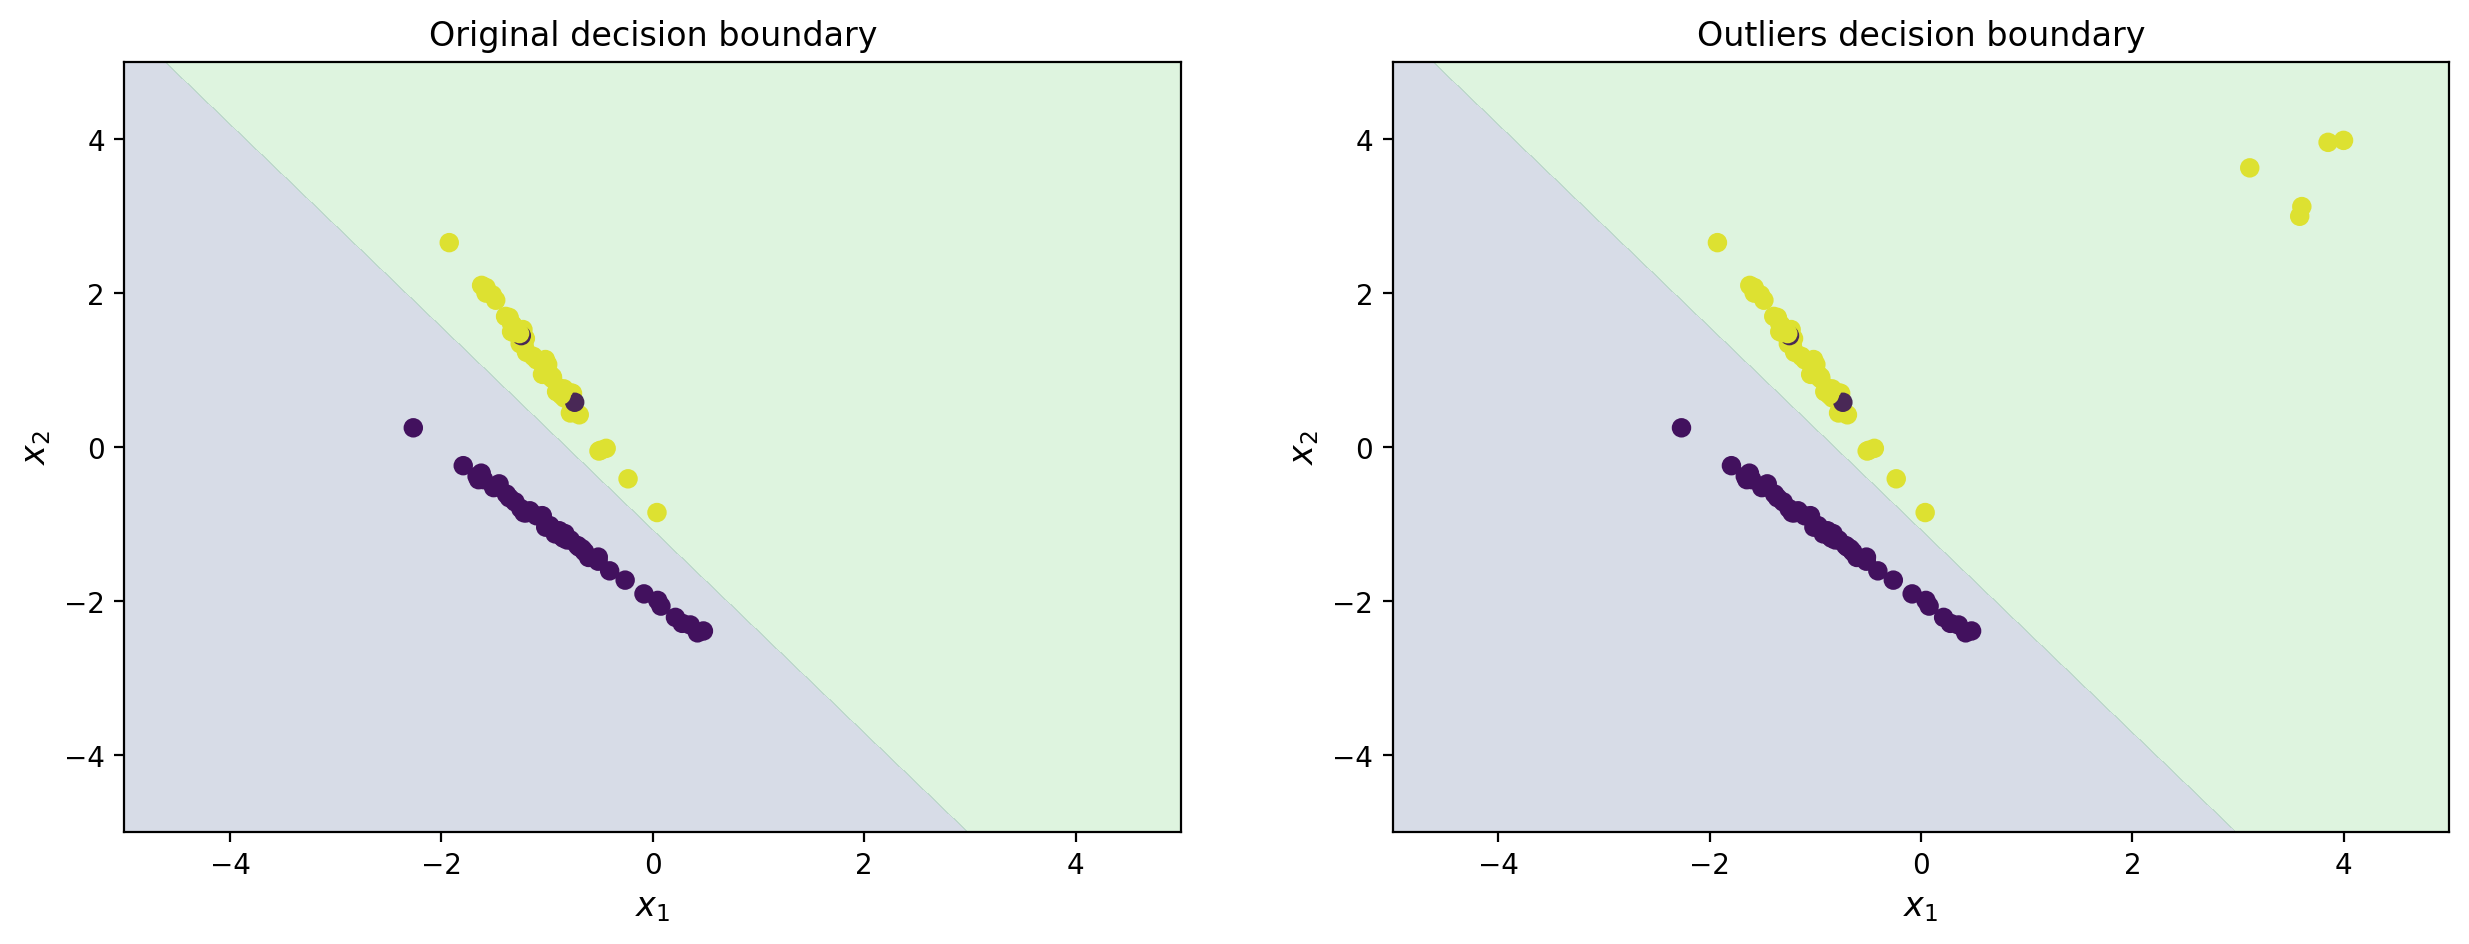

In [16]:
# number of training points
N = 100

# number of outlier points
n_outliers = 5

x_train, t = make_classification(
    n_features=2, n_informative=2, n_redundant=0, n_classes=2, n_clusters_per_class=1, n_samples=N, random_state=12
)

x1, x2 = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
x_test = np.array([x1, x2]).reshape(2, -1).T

outliers = np.random.random_sample((n_outliers, 2)) + 3
x_train_outliers = np.vstack((x_train, outliers))
t_outliers = np.hstack((t, np.ones(n_outliers, dtype=int)))

feature = LinearFeature()
x_train_linear = feature.transform(x_train)
x_train_linear_outliers = feature.transform(x_train_outliers)
x_test_linear = feature.transform(x_test)

model = LogisticRegression()
model.fit_lms(x_train_linear, t, 0.01)
predicted = model.predict(x_test_linear)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(x_train[:, 0], x_train[:, 1], c=t)
plt.contourf(x1, x2, predicted.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$x_2$", fontsize=12)
plt.title("Original decision boundary")

model.fit_lms(x_train_linear_outliers, t_outliers, 0.01)
predicted_outliers = model.predict(x_test_linear)

plt.subplot(1, 2, 2)
plt.scatter(x_train_outliers[:, 0], x_train_outliers[:, 1], c=t_outliers)
plt.contourf(x1, x2, predicted_outliers.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$x_2$", fontsize=12)
plt.title("Outliers decision boundary")

plt.show()

Note that logistic regression is robust to outliers in contrast to linear discriminants presented in section [4.1](#4.1-Discriminant-Functions).

### 4.3.3 Iterative reweighted least squares

In linear regression models, the maximum likelihood solution, on the assumption of Gaussian noise model, leads to a closed-form solution. For logistic regression, there is no longer a closed-form solution, due to the nonlinearity of the logistic sigmoid function. However, the error function is still convex and can be minimized by an efficient iterative technique based on *Newton-Raphson* iterative optimization scheme. This algorithm uses a local quadratic approximation to the log-likelihood, and takes the form

$$
\mathbf{w}^{new} = \mathbf{w}^{old} - \mathbf{H}^{-1}\nabla E(\mathbf{w})
$$

where $\mathbf{H}$ is the Hessian matrix whose elements comprise the second derivatives of $E(\mathbf{w})$ over $\mathbf{w}$.

Note that, if we apply the *Newton-Raphson* algorithm to the linear regression model, we derive the standard least squares solution (see $4.94$ and $4.95$).

Applying the *Newton-Raphson* update to the cross-entropy error function for the logistic regression model, we obtain,

$$
\nabla E(\mathbf{w}) = \sum_{n=1}^N(y_n-t_n)\boldsymbol\phi_n = \boldsymbol\Phi^T(\mathsf{y}-\mathsf{t})
$$

and

$$
\begin{aligned}
\mathbf{H} &= \nabla\nabla E(\mathbf{w}) \\
&= \nabla\sum_{n=1}^N(y_n-t_n)\boldsymbol\phi_n \\
&= \nabla\sum_{n=1}^N y_n\boldsymbol\phi_n \\
&\overset{(4.88)}{=} \sum_{n=1}^N y_n(1-y_n)\boldsymbol\phi_n\frac{d}{d\mathbf{w}}\mathbf{w}^T\boldsymbol\phi_n \\ 
&= \sum_{n=1}^N y_n(1-y_n)\boldsymbol\phi_n\boldsymbol\phi_n^T \\
&= \mathbf{\Phi}^T\mathbf{R}\mathbf{\Phi}
\end{aligned}
$$

where $\mathbf{R}$ is a diagonal matrix whose elements are $R_{nn}=y_n(1-y_n)$. Then, the update formula becomes,

$$
\mathbf{w}^{new} = \mathbf{w}^{old} - (\mathbf{\Phi}^T\mathbf{R}\mathbf{\Phi})^{-1}\boldsymbol\Phi^T(\mathsf{y}-\mathsf{t})
$$

Note that Hessian depends on $\mathbf{w}$ through the weighting matrix $\mathbf{R}$, corresponding to the fact that the error function is no longer quadratic. Thus, we must apply the update formula iteratively, each time using the new weight vector $\mathbf{w}$ to compute the revised weighting matrix $\mathbf{R}$. To that end, the algorithm is known as *iterative reweighted least squares* or *IRLS*.

The elements of $\mathbf{R}$ can be interpreted as variances, given by,

$$
\mathbb{E}[t] = \sum_{t\in\{0,1\}} t p(t|\mathbf{x}) = \sigma(x)
$$

and

$$
\text{var}[t] = \mathbb{E}[t^2] - \mathbb{E}[t]^2 \overset{t^2 = t}{=} \mathbb{E}[t] - \mathbb{E}[t]^2 =
\sigma(x) - \sigma(x)^2 = y(1-y)
$$

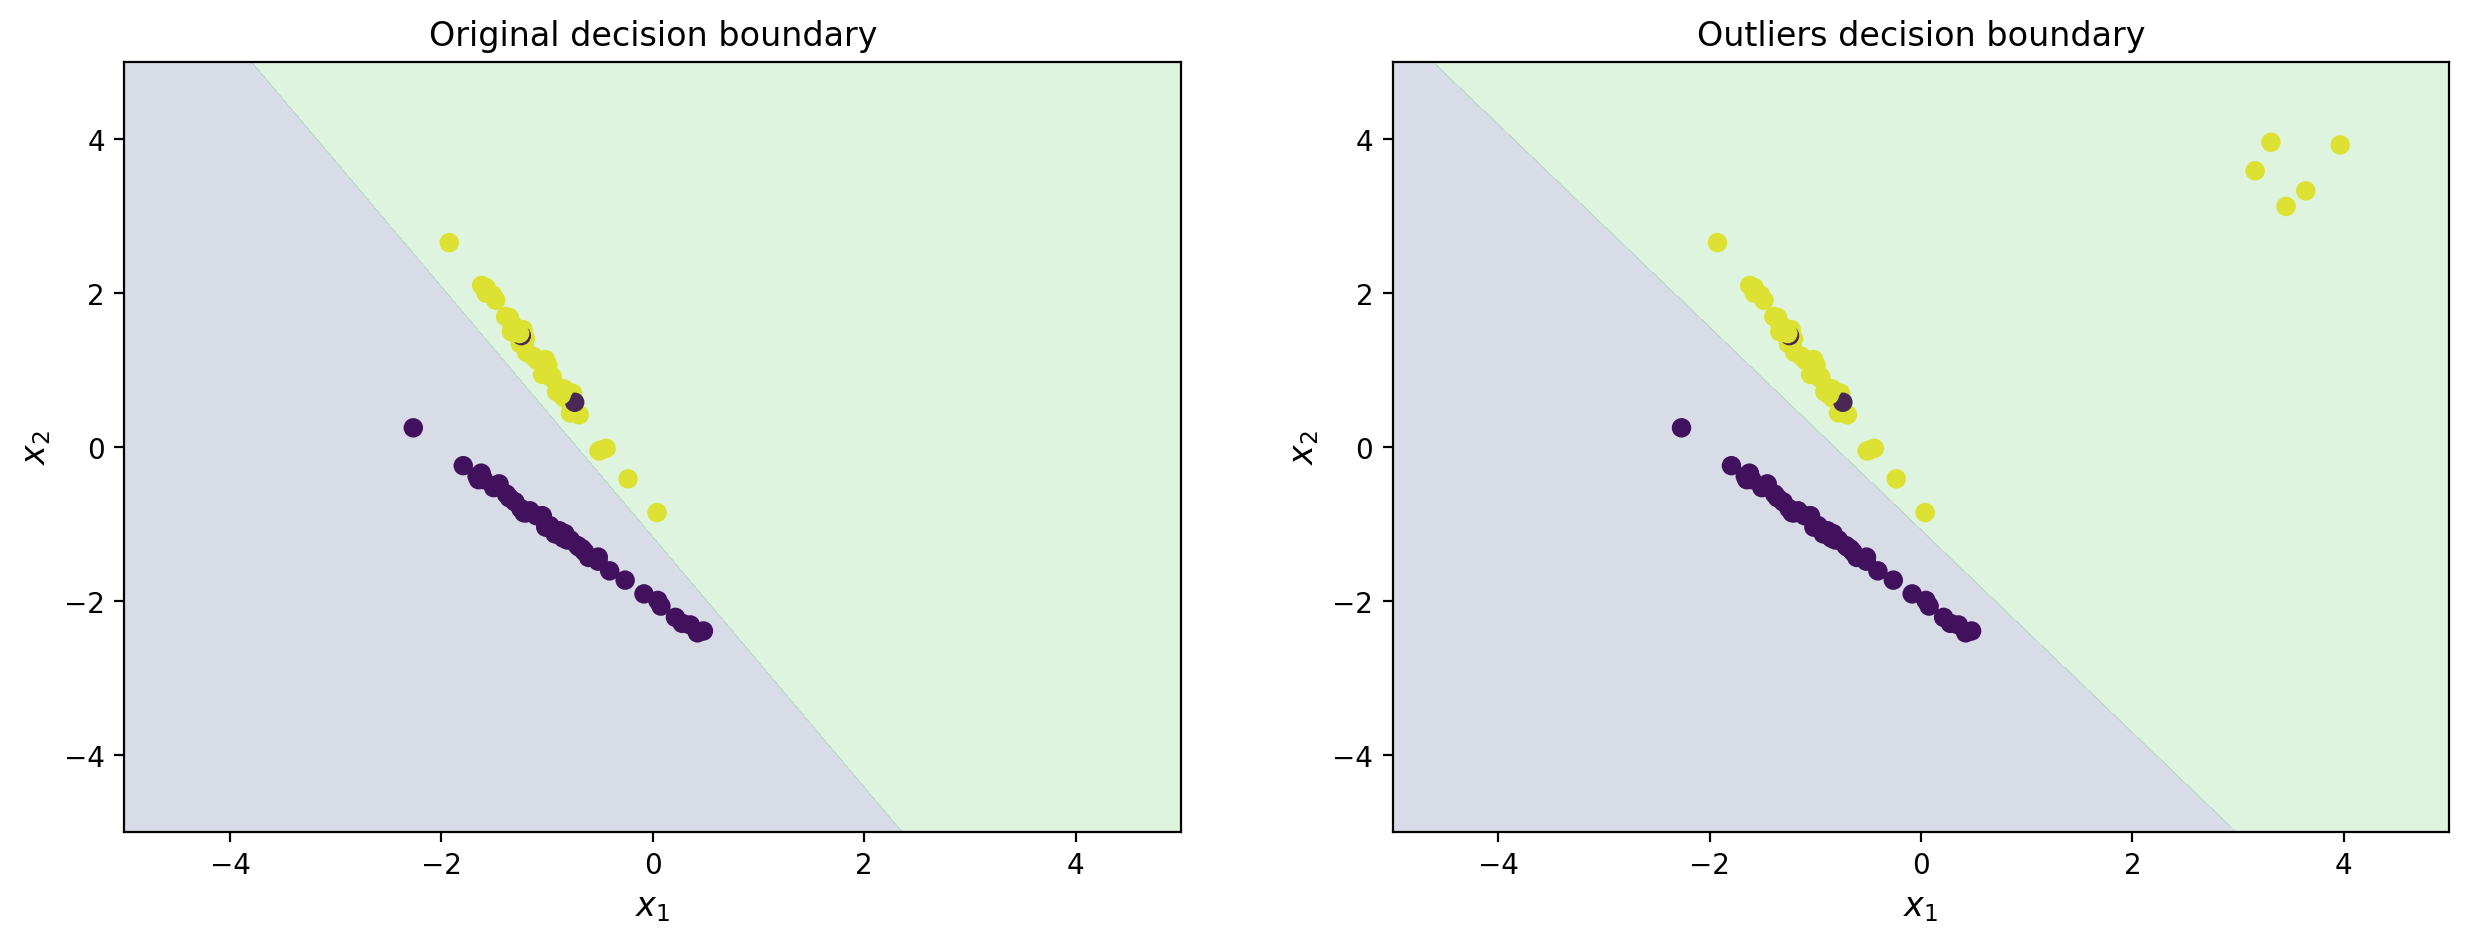

In [17]:
# number of training points
N = 100

# number of outlier points
n_outliers = 5

x_train, t = make_classification(
    n_features=2, n_informative=2, n_redundant=0, n_classes=2, n_clusters_per_class=1, n_samples=N, random_state=12
)

x1, x2 = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
x_test = np.array([x1, x2]).reshape(2, -1).T

outliers = np.random.random_sample((n_outliers, 2)) + 3
x_train_outliers = np.vstack((x_train, outliers))
t_outliers = np.hstack((t, np.ones(n_outliers, dtype=int)))

feature = LinearFeature()
x_train_linear = feature.transform(x_train)
x_train_linear_outliers = feature.transform(x_train_outliers)
x_test_linear = feature.transform(x_test)

model = LogisticRegression()
model.fit(x_train_linear, t)
predicted = model.predict(x_test_linear)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(x_train[:, 0], x_train[:, 1], c=t)
plt.contourf(x1, x2, predicted.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$x_2$", fontsize=12)
plt.title("Original decision boundary")

model.fit_lms(x_train_linear_outliers, t_outliers, 0.01)
predicted_outliers = model.predict(x_test_linear)

plt.subplot(1, 2, 2)
plt.scatter(x_train_outliers[:, 0], x_train_outliers[:, 1], c=t_outliers)
plt.contourf(x1, x2, predicted_outliers.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$x_2$", fontsize=12)
plt.title("Outliers decision boundary")

plt.show()

### [Gradient Descent vs Newton-Raphson](https://www.youtube.com/watch?v=iwO0JPt59YQ)

Newton-Raphson method requires to compute the Hessian (through solving a set of linear equations) and thus, the computational cost for each iteration is higher than that of gradient descent. However, it usually converges faster than gradient descent in the sense that the number of iterations required is much smaller.

### 4.3.4 Multiclass logistic regression

We have seen that for $K>2$ classes, the posterior probabilities are given by a softmax transformation of linear functions of feature variables. Here, we consider the maximum likelihood to determine the parameters $\mathbf{w}_k$ of the model directly. To that end, we need to calculate the derivatives of $y_k$ (see $4.104$) over the activation functions $\alpha_j$ (see $4.68$ and $4.105$).

In order to find the derivatives, we need to consider $k\neq j$ and $k=j$.

1. $k\neq j$

$$
\begin{aligned}
\frac{\partial y_k}{\partial\alpha_k} 
&= \frac{\partial}{\partial\alpha_k} \frac{\exp(\alpha_k)}{\sum_j \exp(\alpha_j)} \\
&= \frac{-\exp(\alpha_k)\exp(\alpha_j)}{\big(\sum_j \exp(\alpha_j)\big)^2} \\
&= -\frac{\exp(\alpha_k)}{\sum_j \exp(\alpha_j)}\frac{\exp(\alpha_j)}{\sum_j \exp(\alpha_j)} \\
&\overset{4.104}{=} -y_k y_j
\end{aligned}
$$

2. $k=j$

$$
\begin{aligned}
\frac{\partial y_k}{\partial\alpha_k} 
&= \frac{\partial}{\partial\alpha_k} \frac{\exp(\alpha_k)}{\sum_j \exp(\alpha_j)} \\
&= \frac{\exp(\alpha_k)\sum_j \exp(\alpha_j) - \exp(\alpha_k)^2}{\big(\sum_j \exp(\alpha_j)\big)^2} \\
&= \frac{\exp(\alpha_k)\sum_j \exp(\alpha_j)}{\big(\sum_j \exp(\alpha_j)\big)^2} - \frac{\exp(\alpha_k)^2}{\big(\sum_j \exp(\alpha_j)\big)^2}\\
&= \frac{\exp(\alpha_k)}{\sum_j \exp(\alpha_j)} - \bigg(\frac{\exp(\alpha_k)}{\sum_j \exp(\alpha_j)}\bigg)^2\\
&=  y_k - y_k^2 \\
&= y_k(1-y_k)
\end{aligned}
$$

where we have used the quotient rule $\big(\frac{f}{g}\big)'=\frac{f'g-fg'}{g^2}$.


Combining $(1)$ and $(2)$, we obtain,

$$
\frac{\partial y_k}{\partial\alpha_k} = y_k(I_{kj}-y_j)
$$

where $I_{kj}$ are the elements of the identity matrix.

Assuming a $1$-of-$K$ coding scheme in which the target vector $\mathbf{t}_k$ is a binary vector having all elements zero except for element $k$, which equals to one, then ,the likelihood function is then given by,

$$
p(\mathbf{T}|\mathbf{w}_1,\dots,\mathbf{w}_k) = 
\prod_{n=1}^N \prod_{k=1}^K p(\mathbf{C}_k|\boldsymbol\phi_n)^{t_{nk}} =
\prod_{n=1}^N \prod_{k=1}^K y_k(\boldsymbol\phi_n)^{t_{nk}}
$$

where $\mathbf{T}$ is a $N\times K$ matrix of target variables with elements $t_{nk}$. Taking the negative logarithm the gives,

$$
E(\mathbf{w}_1,\dots,\mathbf{w}_k) = -\ln p(\mathbf{T}|\mathbf{w}_1,\dots,\mathbf{w}_k) = 
-\sum_{n=1}^N \sum_{k=1}^K t_{nk}\ln y_k(\boldsymbol\phi_n)
$$

which is the *cross-entropy* error function for the multiclass problem.

Taking the gradient of the error function over the parameter vector $\mathbf{w}_j$, we obtain

$$
\begin{aligned}
\nabla_{\mathbf{w}_j} E(\mathbf{w}_1,\dots,\mathbf{w}_K) 
&= - \nabla_{\mathbf{w}_j} \sum_{n=1}^N \sum_{k=1}^K t_{nk}\ln y_k(\boldsymbol\phi_n) \\
&= - \sum_{n=1}^N \sum_{k=1}^K t_{nk}\frac{1}{y_{nk}}y_{nk}(I_{kj}-y_{nj})\boldsymbol\phi_n \\
&= - \sum_{n=1}^N \sum_{k=1}^K t_{nk}(I_{kj}-y_{nj})\boldsymbol\phi_n \\
&= \sum_{n=1}^N \sum_{k=1}^K t_{nk}y_{nj}\boldsymbol\phi_n - \sum_{n=1}^N \sum_{k=1}^K t_{nk}I_{kj}\boldsymbol\phi_n \\
&= \sum_{n=1}^N \sum_{k=1}^K t_{nk}y_{nj}\boldsymbol\phi_n - \sum_{n=1}^N t_{nj}\boldsymbol\phi_n \\
&\overset{\sum_k t_{nk}=1}{=} \sum_{n=1}^N y_{nj}\boldsymbol\phi_n - \sum_{n=1}^N t_{nj}\boldsymbol\phi_n \\
&= \sum_{n=1}^N (y_{nj} - t_{nj})\boldsymbol\phi_n
\end{aligned}
$$

The Newton-Raphson update formula, requires the evaluation of the Hessian matrix, given by

$$
\begin{aligned}
\nabla_{\mathbf{w}_k} \nabla_{\mathbf{w}_j} E(\mathbf{w}_1,\dots,\mathbf{w}_K) 
&= - \nabla_{\mathbf{w}_k} \nabla_{\mathbf{w}_j} \ln p(\mathbf{T}|\mathbf{w}_1,\dots,\mathbf{w}_k) \\
&= - \nabla_{\mathbf{w}_k} \sum_{n=1}^N (y_{nj} - t_{nj})\boldsymbol\phi_n \\
&= - \nabla_{\mathbf{w}_k} \sum_{n=1}^N y_{nj}\boldsymbol\phi_n \\
&= \sum_{n=1}^N \frac{\partial}{\partial\mathbf{w}_k}y_{nj}\boldsymbol\phi_n \\
&= \sum_{n=1}^N y_{nk}(I_{kj}-y_{nj})\boldsymbol\phi_n\boldsymbol\phi_n^T \\
\end{aligned}
$$

Below we present a softmax regression example trained using gradient descent.

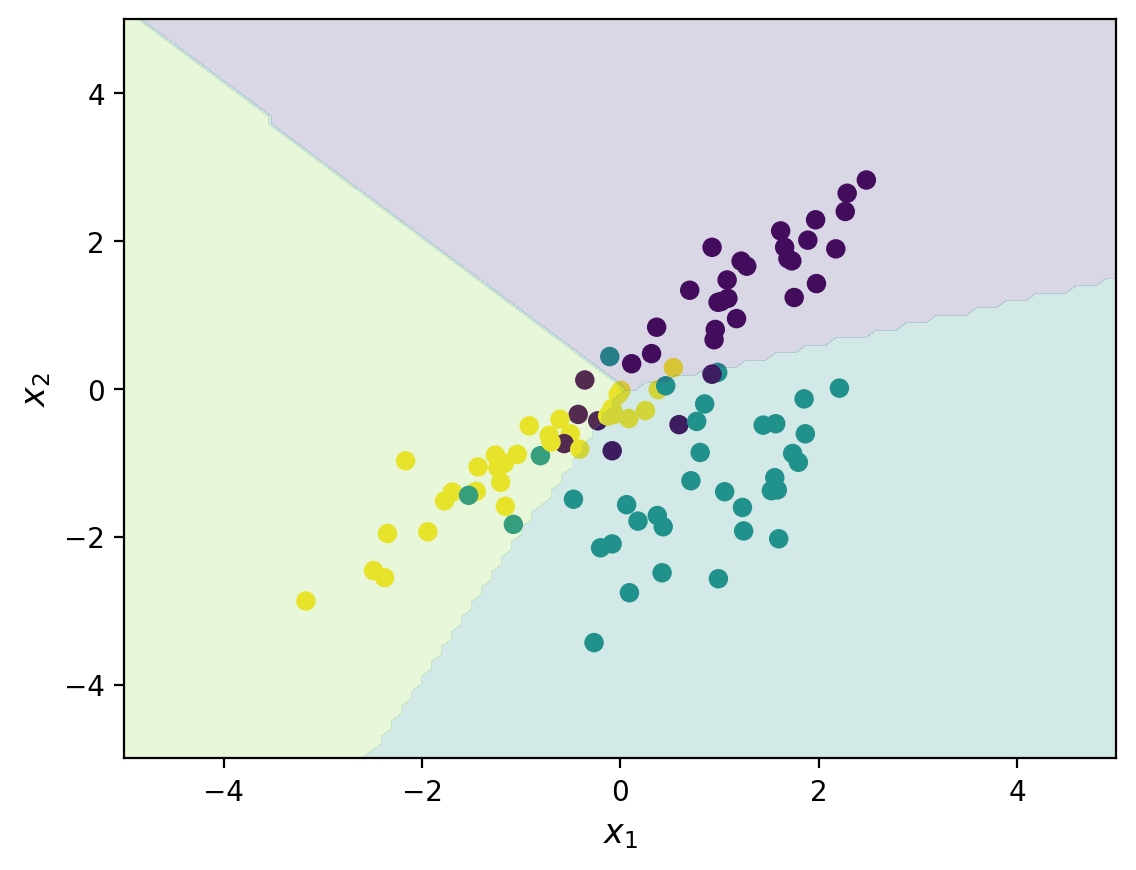

In [18]:
# number of training points
N = 100

x_train, t = make_classification(
    n_features=2, n_informative=2, n_redundant=0, n_classes=3, n_clusters_per_class=1, n_samples=N, random_state=21
)

x1, x2 = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
x_test = np.array([x1, x2]).reshape(2, -1).T

model = SoftmaxRegression()
model.fit(x_train, t)
predicted = model.predict(x_test)

plt.scatter(x_train[:, 0], x_train[:, 1], c=t)
plt.contourf(x1, x2, predicted.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 2, 4))
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$x_2$", fontsize=12)

plt.show()

## 4.4 Laplace Approximation

In contrast to the [Bayesian treatment of linear regression](ch3_linear_models_for_regression.ipynb#3.3-Bayesian-Linear-Regression), in the Bayesian treatment of logistic regression, we cannot integrate exactly over the parameter vector $\mathbf{w}$ since the posterior distribution is no longer Gaussian. To that end, we may use a widely used framework called the Laplace approximation, that aims to find a Gaussian approximation to a probability density defined over a set of continuous variables. Consider a single continuous variable $z$, having a distribution $p(z)$ defined by

$$
p(z) = \frac{1}{Z}f(z)
$$

where $Z=\int f(z)\text{d}z$ is the normalization coefficient. The goal is to find a Gaussian approximation $q(z)$ centered on a mode of the distribution $p(z)$. The first step is to find a mode of $p(z)$, that is, a point $z_0$ such that $p'(z_0)=0$ or equivalently

$$
\frac{df(z)}{dz}\bigg|_{z=z_0} = 0
$$

Then, we use a second-order Taylor expansion to approximate $g(z) = \ln f(z)$ (because the logarithm of any Gaussian distribution is a quadratic function of the variables), centered on the mode $z_0$ so that,

$$
g(z) = \ln f(z) \approx \sum_{n=0}^{2} \frac{g^{(n)}(z_0)}{n!}(z-z_0)^n = g(z_0) - \frac{1}{2}g''(z_0)(z-z_0)^2
$$

Note that the first-order term is omitted since $z_0$ is a local maximum of the distribution and thus the derivative is zero. Then, taking the exponential on both sides of the expansion, we obtain

$$
f(z) \approx f(z_0)\exp\Big\{ -\frac{A}{2}(z-z_0)^2 \Big\}
$$

where $A=-\frac{d^2f(z)}{d^2z}$ on $z_0$. Therefore, using the standard result for the normalization of a Gaussian, the final normalized distribution $q(z)$ has the form,

$$
q(z) = \Big(\frac{A}{2\pi}\Big)^{1/2} \exp\Big\{ -\frac{A}{2}(z-z_0)^2 \Big\} = \mathcal{N}(z|z_0,A)
$$

Note that the Gaussian approximation is well defined only when its precision $A>0$, which implies that $z_0$ must be a local maximum, not a minimum! In practice a mode may be found by running some form of numerical optimization. The Laplace approximation is depicted in the next Figure,

<img src="../images/fg4_14a.png" width="400"/>

The same approximation can be applied to an $M$-dimentional space $\mathbf{z}$.

## 4.5 Bayesian Logistic Regression

Exact Bayesian inference for logistic regression, as well as, the evaluation of the predictive distribution are intractable. Thus, here, we consider the application of Laplace approximation for the problem of Bayesian logistic regression.

### 4.5.1 Laplace approximation

Similar to the Bayesian linear regression, we seek a Gaussian representation for the posterior distribution of the parameters, thus, we use a Gaussian (conjugate) prior in the general form,

$$
p(\mathbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf{m}_0,\mathbf{S}_0)
$$

where $\mathbf{m}_0,\mathbf{S}_0$ are fixed hyperparameters. Then, the posterior over $\mathbf{w}$ is given by

$$
p(\mathbf{w}|\mathsf{t}) \propto p(\mathsf{t}|\mathbf{w})p(\mathbf{w})
$$

Taking the natural logarithm on both sides, and substituting for the prior and the likelihood, we obtain

$$
\ln p(\mathbf{w}|\mathsf{t}) = \ln\Big(\prod_{n=1}^N y_n^{t_n}\{1-y_n\}^{1-t_n}\Big)\ln \mathcal{N}(\mathbf{w}|\mathbf{m}_0,\mathbf{S}_0) = \sum_{n=1}^N\{t_n\ln y_n + (1-t_n)\ln(1-y_n)\} + \frac{1}{(2\pi)^{D/2}|\mathbf{S}_0|^{1/2}} -\frac{1}{2}(\mathbf{w}-\mathbf{m}_0)^T\mathbf{S}_0^{-1}(\mathbf{w}-\mathbf{m}_0)
$$

Then, to obtain the Gaussian approximation of the posterior, first, we maximize the posterior to give the MAP solution $\mathbf{w}_{MAP}$, which corresponds to the mean of the approximated Gaussian. The covariance matrix is then given by the Hessian matrix of the negative log-likelihood,

$$
\mathbf{S}_N^{-1} = -\nabla\nabla\ln p(\mathbf{w}|\mathsf{t}) = \mathbf{S}_0^{-1} + \sum_{n=1}^N y_n(1-y_n)\boldsymbol\phi_n\boldsymbol\phi_n^T
$$

where we make use of $(4.97)$. Thus, the Gaussian approximation of the posterior takes the form,

$$
q(\mathbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf{w}_{MAP},\mathbf{S}_N)
$$

### 4.5.2 Predictive distribution

The predictive distribution for class $\mathcal{C}_1$, given a new feature vector $\boldsymbol\phi_{unseen}$, is obtained by marginalizing over the posterior distribution $p(\mathbf{w}|\mathsf{t})$, which is approximated by $q(\mathbf{w})$, so that,

$$
p(\mathcal{C}_1|\boldsymbol\phi_{unseen},\mathsf{t},\boldsymbol\Phi) = \int p(\mathcal{C}_1|\boldsymbol\phi_{unseen},\mathbf{w})p(\mathbf{w}|\mathsf{t},\boldsymbol\Phi)\text{d}\mathbf{w} \approx \int \sigma(\mathbf{w}^T\boldsymbol\phi)q(\mathbf{w})\text{d}\mathbf{w}
$$

The evalution of the above integral is fairly complex and involves a significant number of steps. For more details see the corresponding section in the book. The final approximate predictive distribution has the form,

$$
p(\mathcal{C}_1|\boldsymbol\phi_{unseen},\mathsf{t}) = \sigma\big(\kappa(\sigma_{\alpha}^2)\mu_{\alpha}\big)
$$

where $\kappa(\sigma_{\alpha}^2) = (1+ \pi\sigma_{\alpha}^2/8)^{-1/2}$, $\mu_a = \mathbf{w}_{MAP}^T\boldsymbol\phi_{unseen}$, and $\sigma_{\alpha} = \boldsymbol\phi_{unseen}^T\mathbf{S}_N\boldsymbol\phi_{unseen}$.

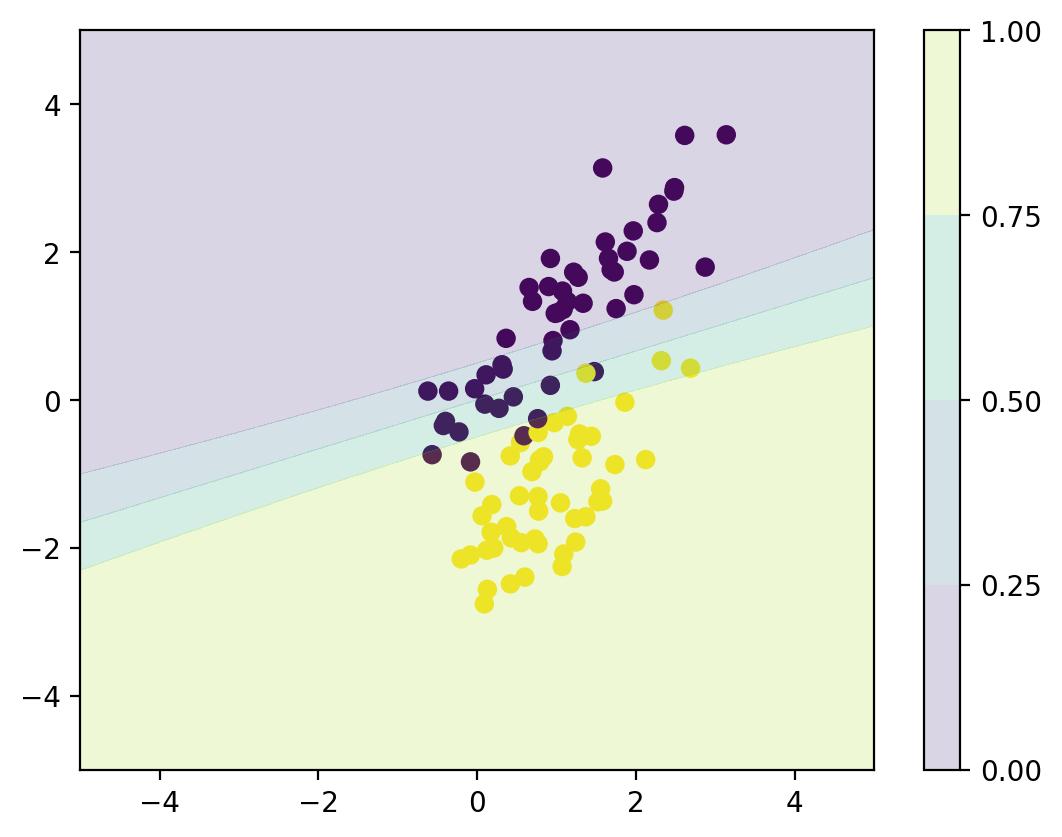

In [19]:
# number of training points
N = 100

x_train, t = make_classification(
    n_features=2, n_informative=2, n_redundant=0, n_classes=2, n_clusters_per_class=1, n_samples=N, random_state=21
)

x1, x2 = np.meshgrid(np.linspace(-5, 5, N), np.linspace(-5, 5, N))
x_test = np.array([x1, x2]).reshape(2, -1).T

model = BayesianLogisticRegression()
model.fit(x_train, t)
predicted = model.predict(x_test)

plt.scatter(x_train[:, 0], x_train[:, 1], c=t)
plt.contourf(x1, x2, predicted.reshape(N, N), alpha=0.2, levels=np.linspace(0, 1, 5))
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.colorbar()
plt.show()